In [308]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [378]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score,KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [310]:
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [311]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [329]:
df_train.isnull().sum()[df_train.isnull().sum() >0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

In [331]:
removed_cols = ['PoolQC','MiscFeature','Alley','Fence']
df_train.drop(columns=removed_cols,inplace =True)

Expected important variables:

OverallQual (which is a variable that I don't like because I don't know how it was computed; a funny exercise would be to predict 'OverallQual' using all the other variables available).

YearBuilt.

TotalBsmtSF.

GrLivArea.

In [332]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Density'>

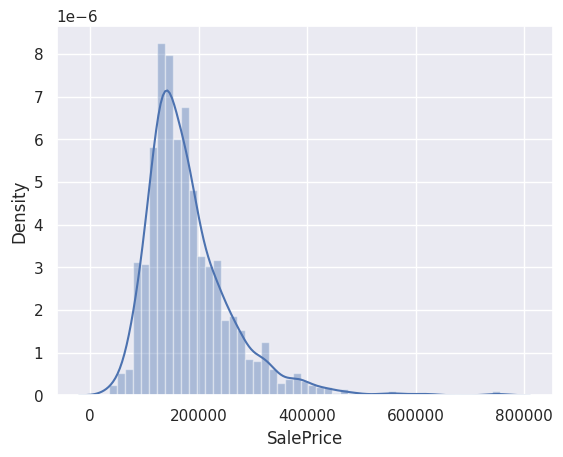

In [333]:
#histogram
sns.distplot(df_train['SalePrice'])

In [334]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [335]:
# For Numerical Columns
def hist_box_scat_graph(columns_list,df,target_column='SalePrice'):
    '''
    columns_list: list of columns you want to plot.
    df: Dataframe from which columns to be plot.
    target_column : column against which you want to plot scatter plot.
    '''
    for col in columns_list:
        plt.figure(figsize=(15, 3))
        plt.title(col)
        
        plt.subplot(1,3,1)
        sns.histplot(x = df[col], kde=True)
        plt.xlabel(col)
        plt.ylabel('Frequency')
    
        plt.subplot(1,3,2)
        sns.boxplot(x=df[col])
        
        plt.subplot(1,3,3)
        sns.scatterplot(x=df[col],y=df[target_column])
        
        plt.show()
        plt.close()

In [336]:
### For Categorical Columns

def bar_box_pie_plot(cat_col_list,df,target_column = 'SalePrice'):
    '''
    columns_list: list of columns you want to plot.
    df: Dataframe from which columns to be plot.
    target_column : column against which you want to plot boxplot.
    '''
    for col in cat_col_list:
        temp = df[col].value_counts().reset_index()
        temp.columns = [col, 'Count']
        
        plt.figure(figsize=(15, 3))
        plt.title(col)
        
        plt.subplot(1,3,1)
        sns.barplot(temp,x=col,y='Count')
        plt.xticks(rotation=90)
        
        plt.subplot(1,3,2)
        sns.boxplot(df,x=col,y = target_column)
        plt.xticks(rotation=90)
        
        plt.subplot(1,3,3)
        plt.pie(x = temp['Count'],autopct='%.2f',labels=temp[col])
        plt.show()
        plt.close()

In [337]:
num_cols = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea',
           'GarageArea', 'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal','SalePrice']

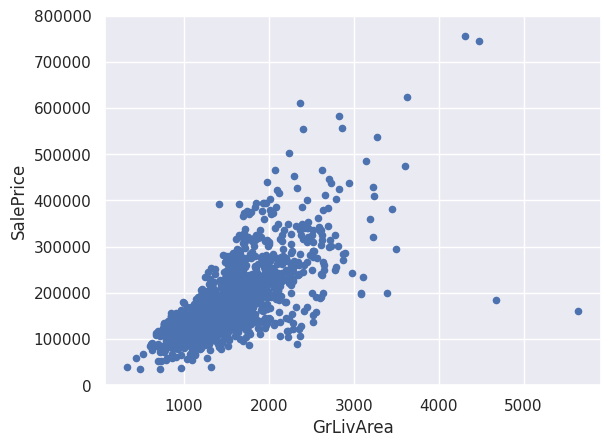

In [338]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

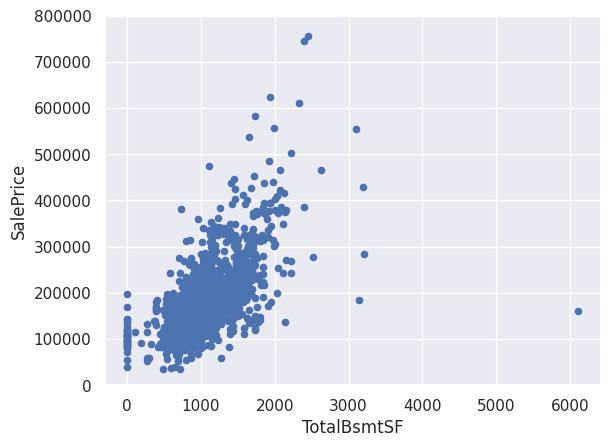

In [339]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000));

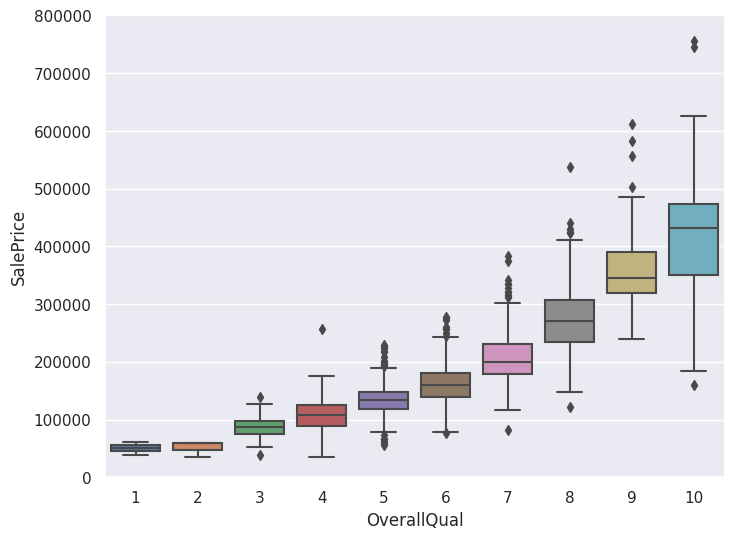

In [340]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000);

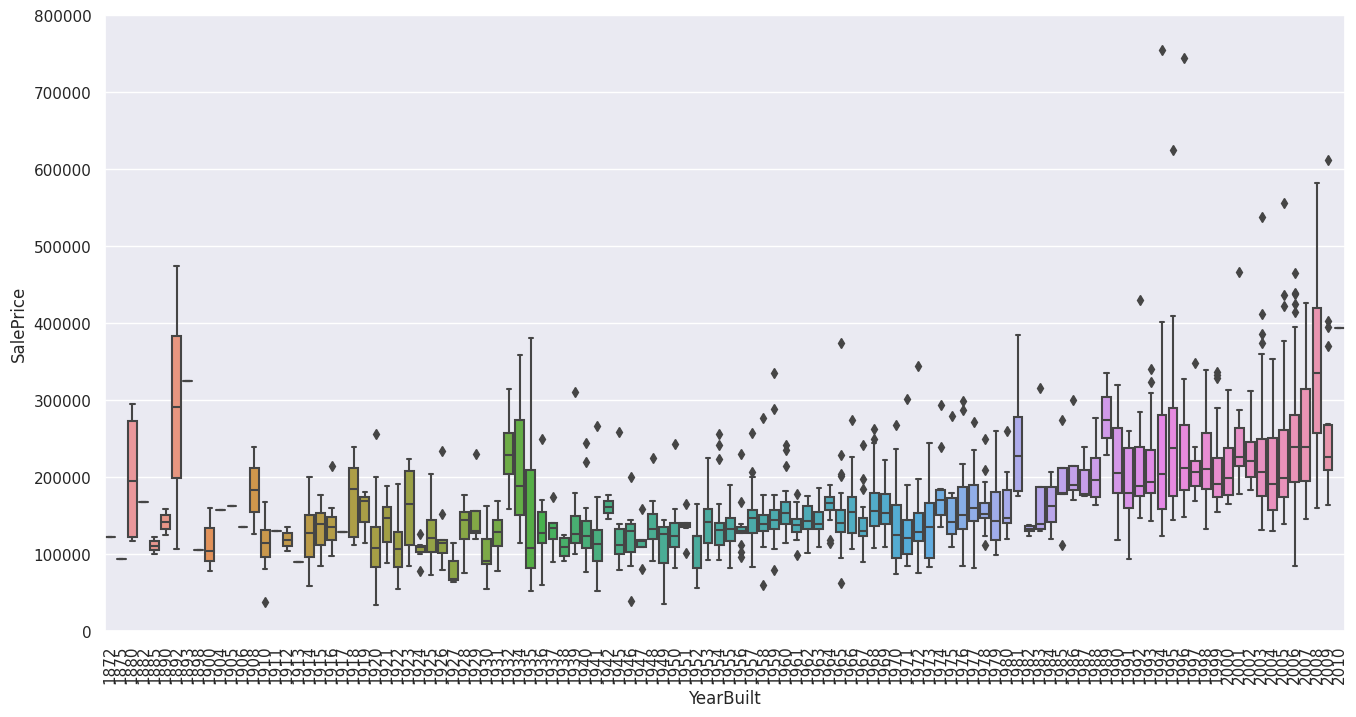

In [341]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

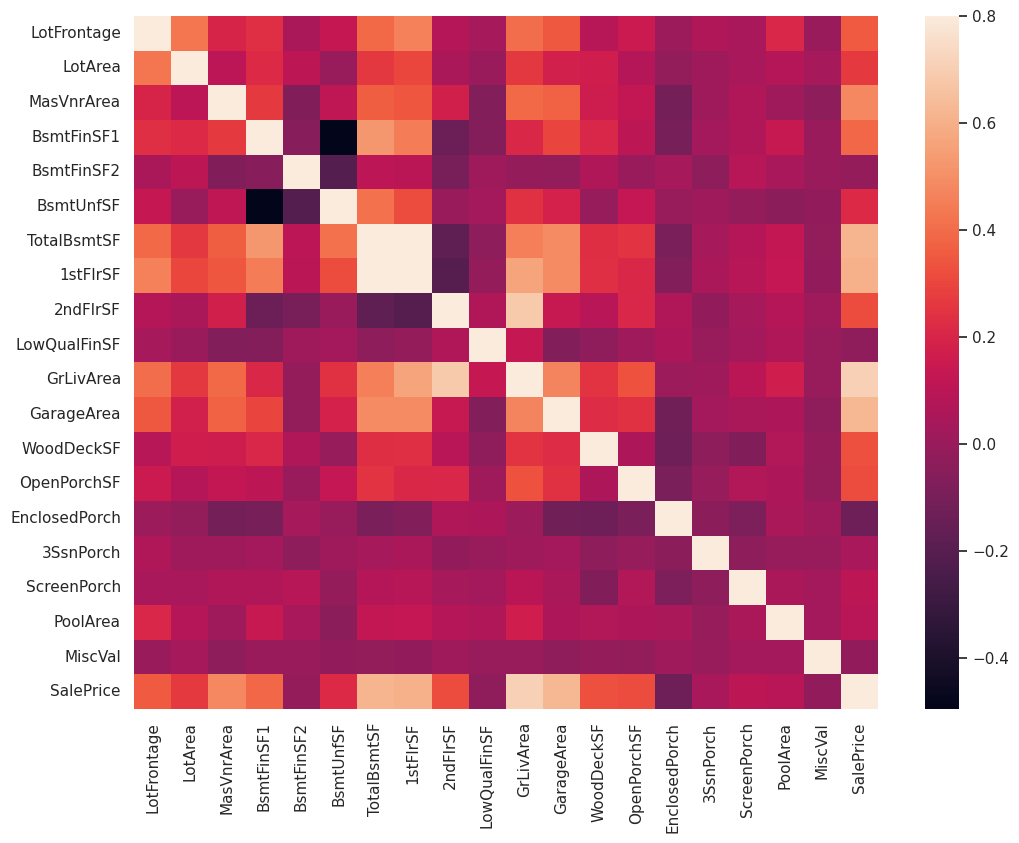

In [342]:
#correlation matrix
df_numerical = df_train[num_cols]
corrmat = df_numerical.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=False);

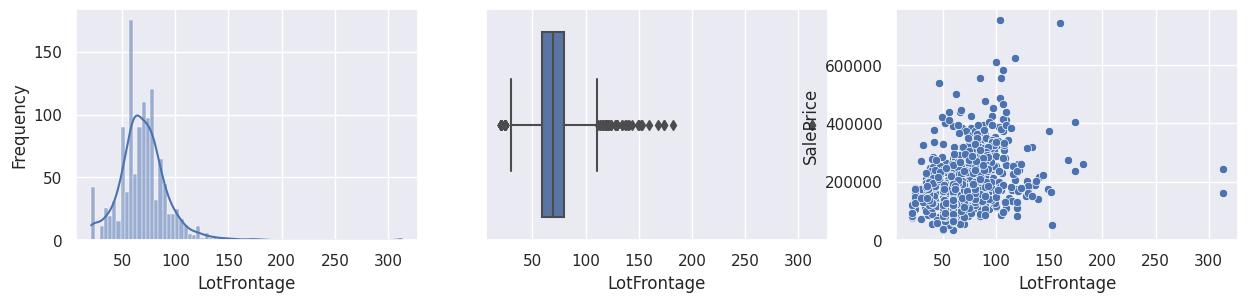

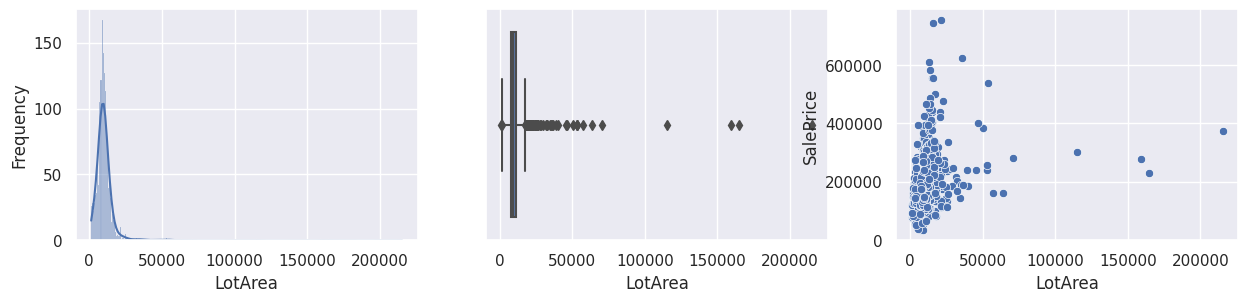

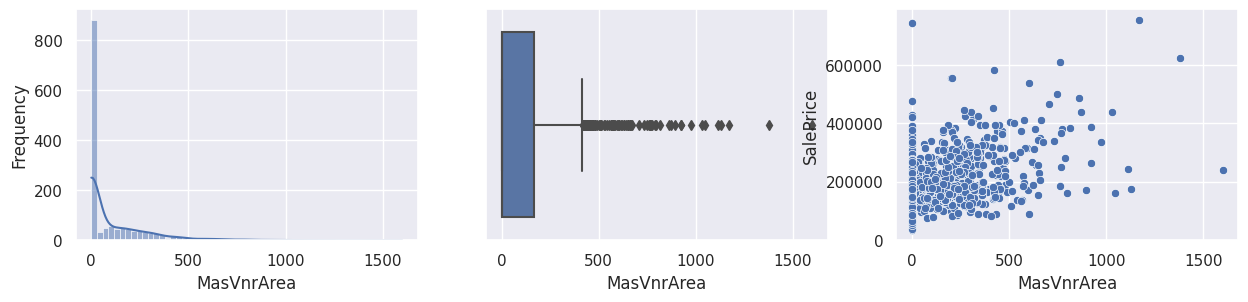

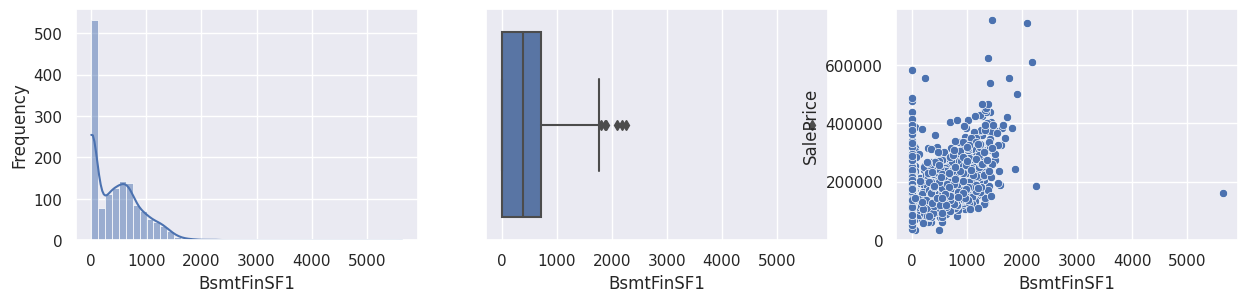

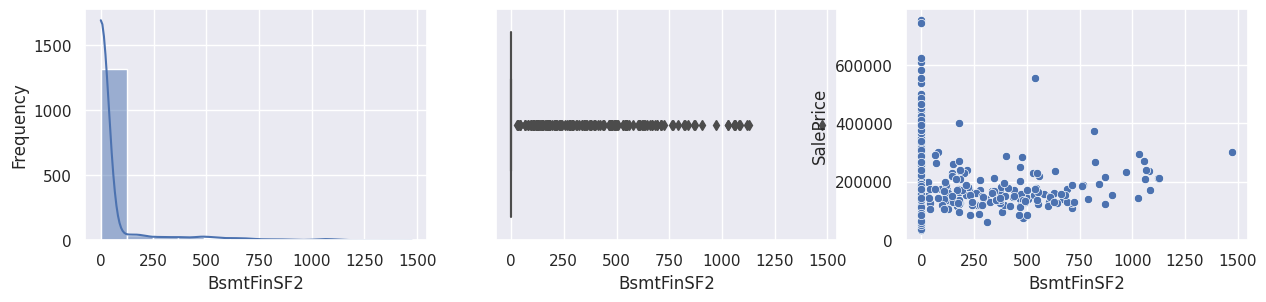

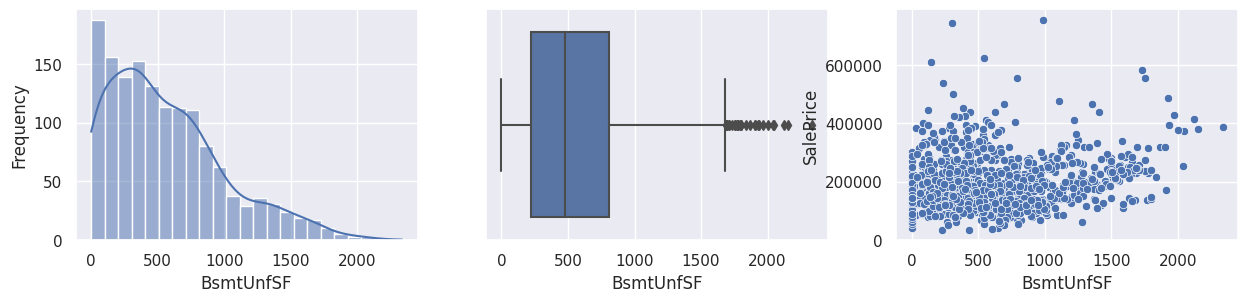

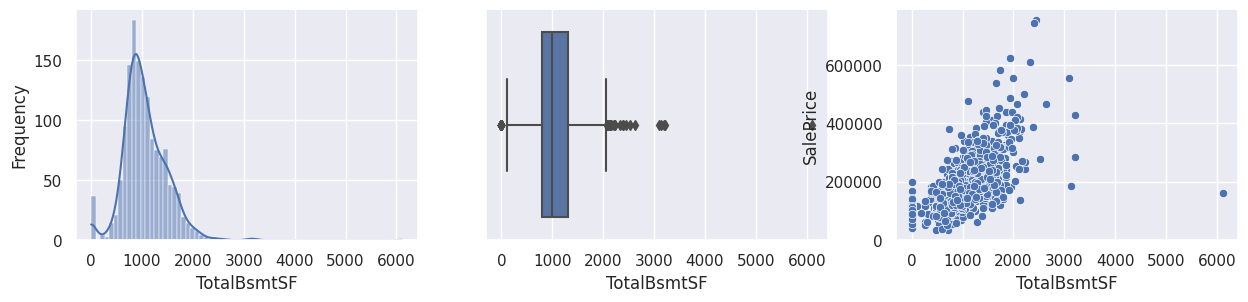

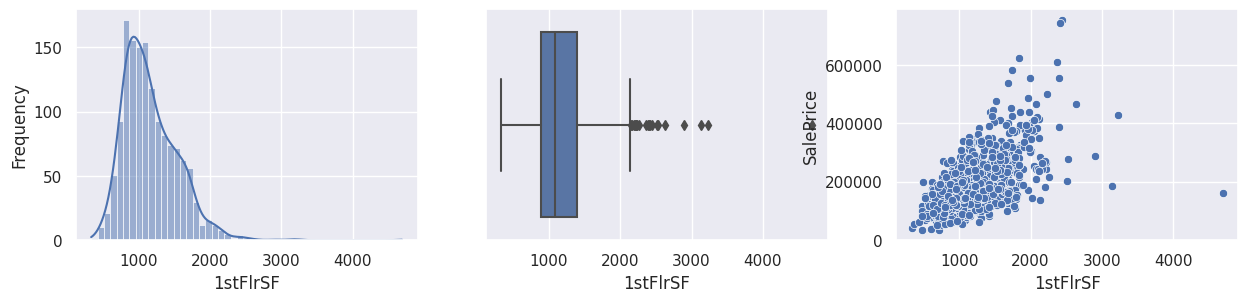

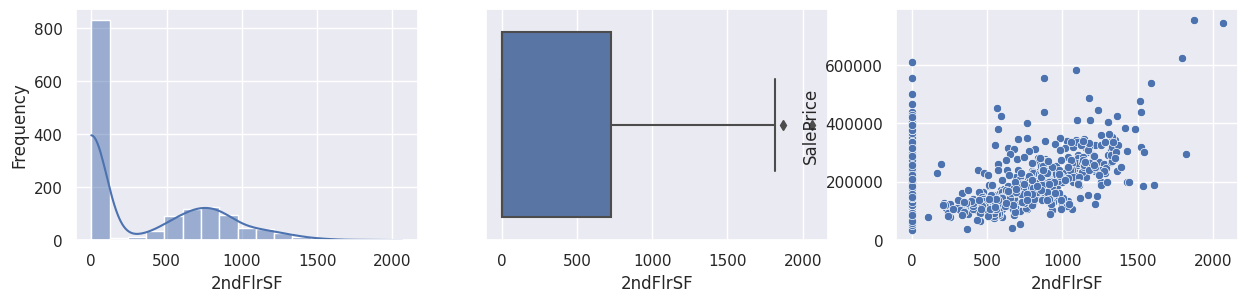

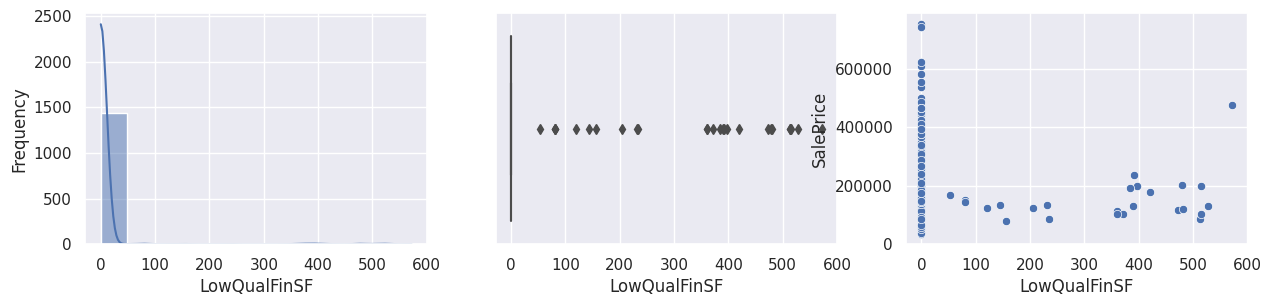

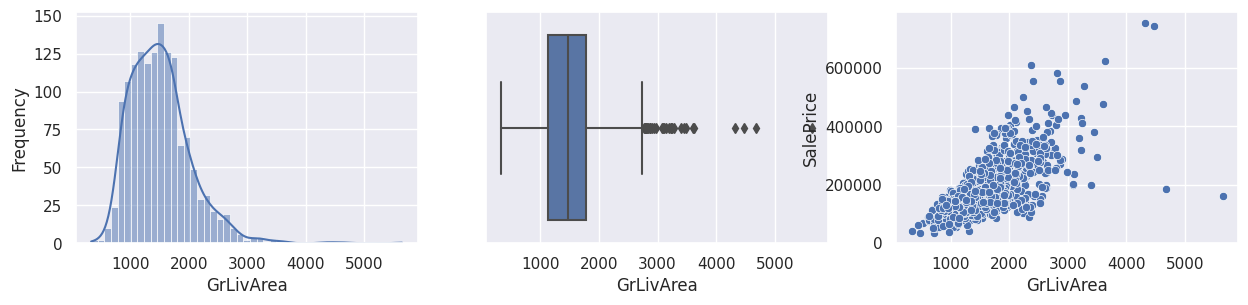

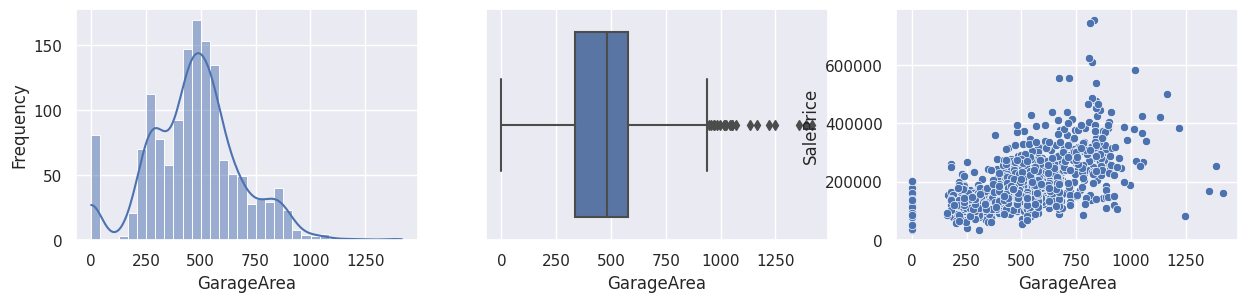

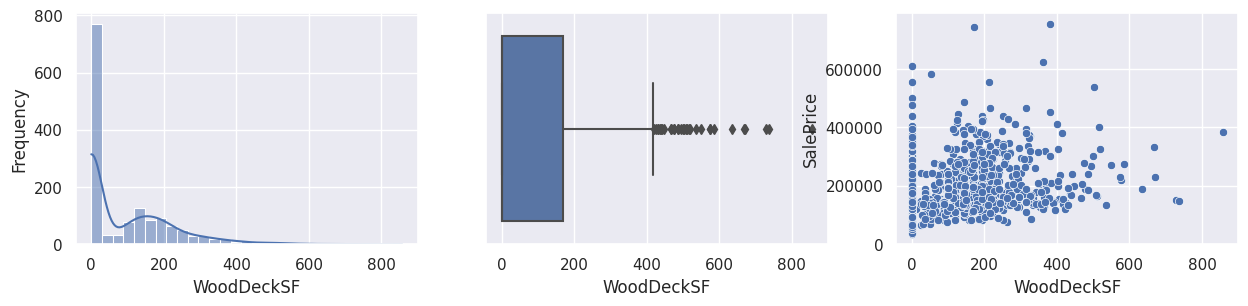

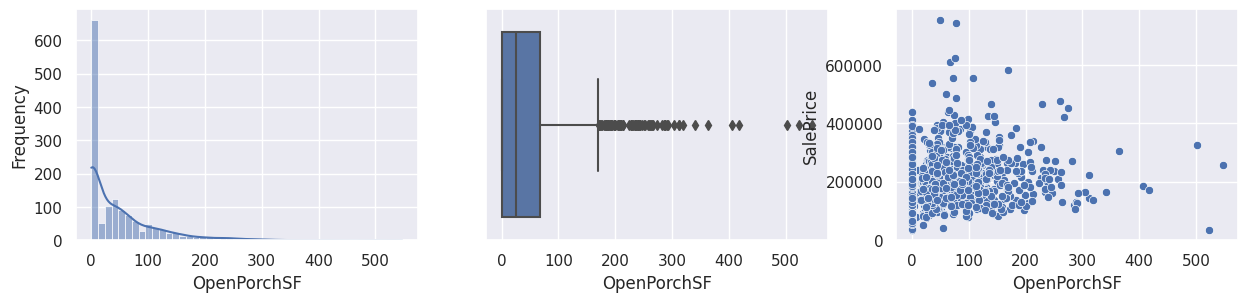

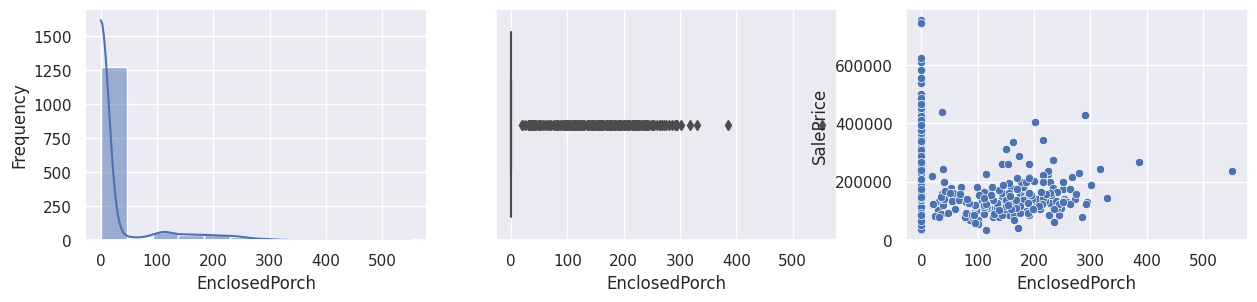

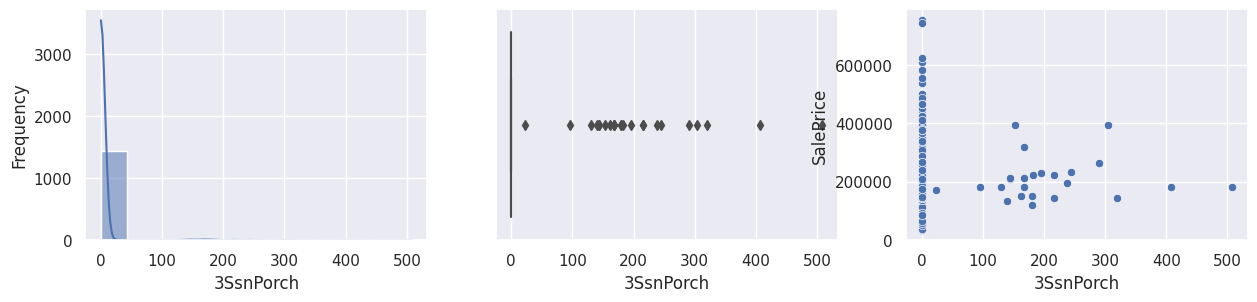

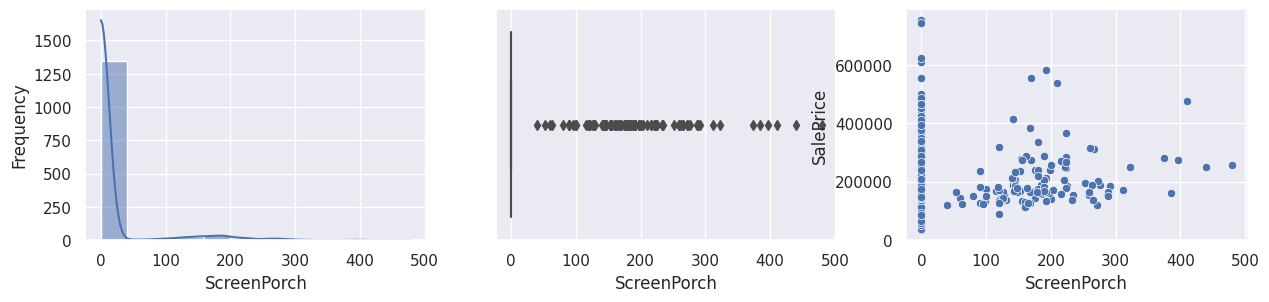

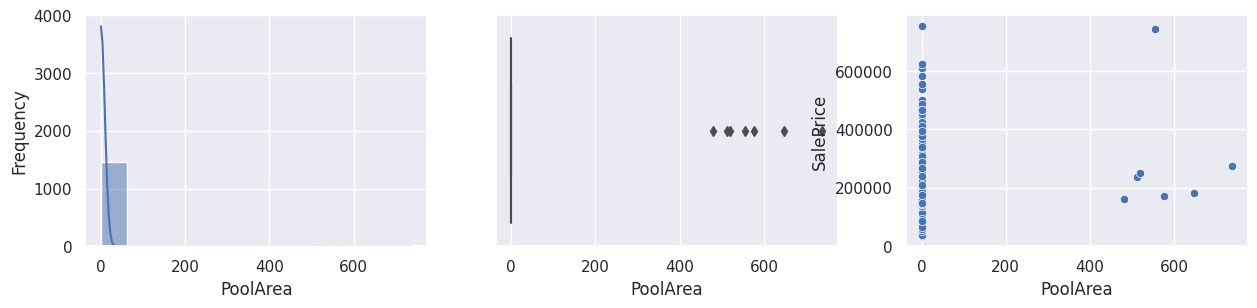

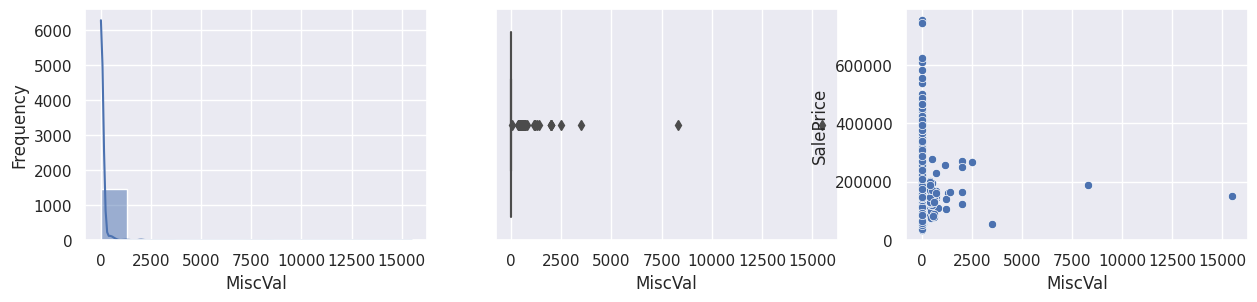

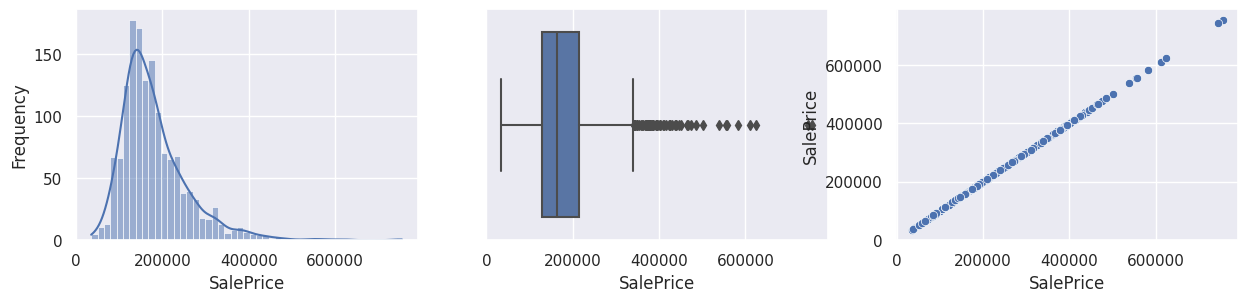

In [343]:
hist_box_scat_graph(num_cols,df_train)

Observations

- There are lot of columns which have extreme no. of Zero values. These are 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'. We will simply drop these Columns.
- Lot of Columns have highly skewed data and outliers. So we will do log transformation and remove outliers.
- 'TotalBsmtSF' is a sum of these Basement columns 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'. That's why they have also have mild collinearity with the column. We will drop these.
- Similarly '1stFlrSF', '2ndFlrSF' is correlated with GrLivArea. they also have multicollinearity with other columns also.
- It also seems that LotFrontage and LotArea might be linearly Correlated. We have to look further into it by removing outliers and log transformation.
- Columns to Remove: 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF'

In [344]:
cols_remove = ['LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF']
df_train.drop(columns=cols_remove,inplace =True)
removed_cols += cols_remove

In [345]:
for i in cols_remove:
    num_cols.remove(i)

In [348]:
temp_df = df_train[['LotFrontage','LotArea','SalePrice']].copy()
temp_df[temp_df['LotArea'] > 100000].index

Index([249, 313, 335, 706], dtype='int64')

In [349]:
temp_df[temp_df['LotFrontage'] > 200].index


Index([934, 1298], dtype='int64')

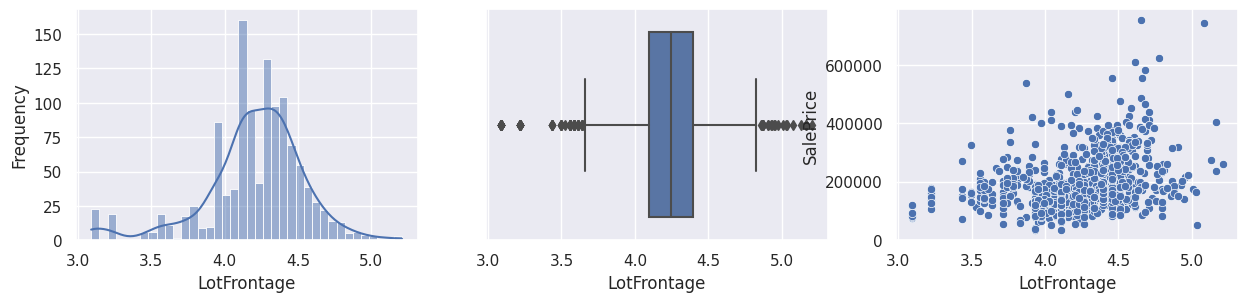

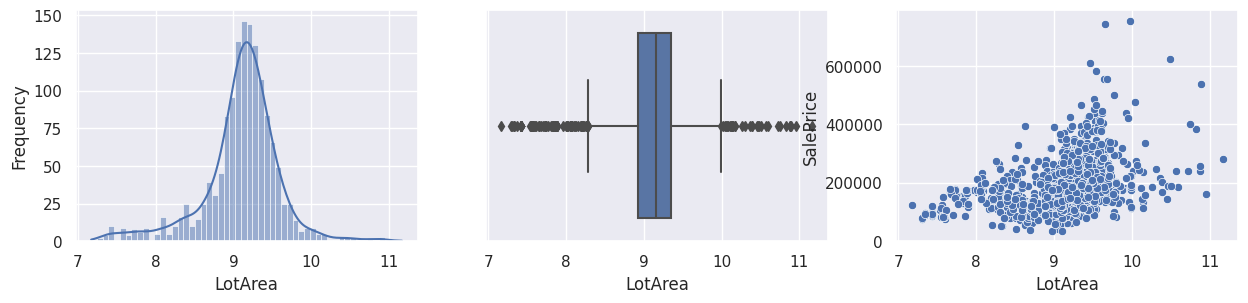

In [350]:
temp_df.drop([249, 313, 335, 706,934, 1298],inplace =True)
temp_df['LotFrontage'] = np.log1p(temp_df['LotFrontage'])
temp_df['LotArea'] = np.log1p(temp_df['LotArea'])
hist_box_scat_graph(['LotFrontage','LotArea'],temp_df)

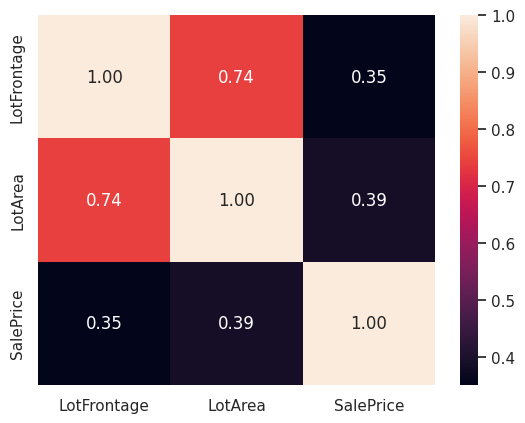

In [351]:
sns.heatmap(temp_df.corr(numeric_only=True),annot=True, fmt=".2f")
plt.show()

Above Experiment Prove that LotFrontage and LotArea are highly correlated. So now we will remove the outliers from our data and remove LotFrontage column and also perform LogTransformation on skewed columns.

In [352]:
outliers_rows = []
outliers_rows +=list(df_train[df_train['LotArea'] > 100000].index)
outliers_rows += list(df_train[df_train['TotalBsmtSF'] > 4000].index)
df_train.drop(outliers_rows,inplace = True)

In [355]:
# Log Transformation:
for i in ['LotArea', 'GrLivArea', 'MasVnrArea','WoodDeckSF','OpenPorchSF']:
    df_train[i] = np.log1p(df_train[i])
    
    
## Skewness:
for i in ['LotArea','TotalBsmtSF','GrLivArea', 'MasVnrArea','WoodDeckSF','OpenPorchSF']:
    print(f'Skewness of {i}: {df_train[i].skew()}')

Skewness of LotArea: -0.6986806172905351
Skewness of TotalBsmtSF: 0.5762837921321455
Skewness of GrLivArea: -0.04124713400122581
Skewness of MasVnrArea: 0.4970481845754487
Skewness of WoodDeckSF: 0.15473775067300993
Skewness of OpenPorchSF: -0.023044318112576366


In [357]:
removed_cols += ['LotFrontage']
df_train.drop(columns='LotFrontage',inplace = True)
num_cols.remove('LotFrontage')

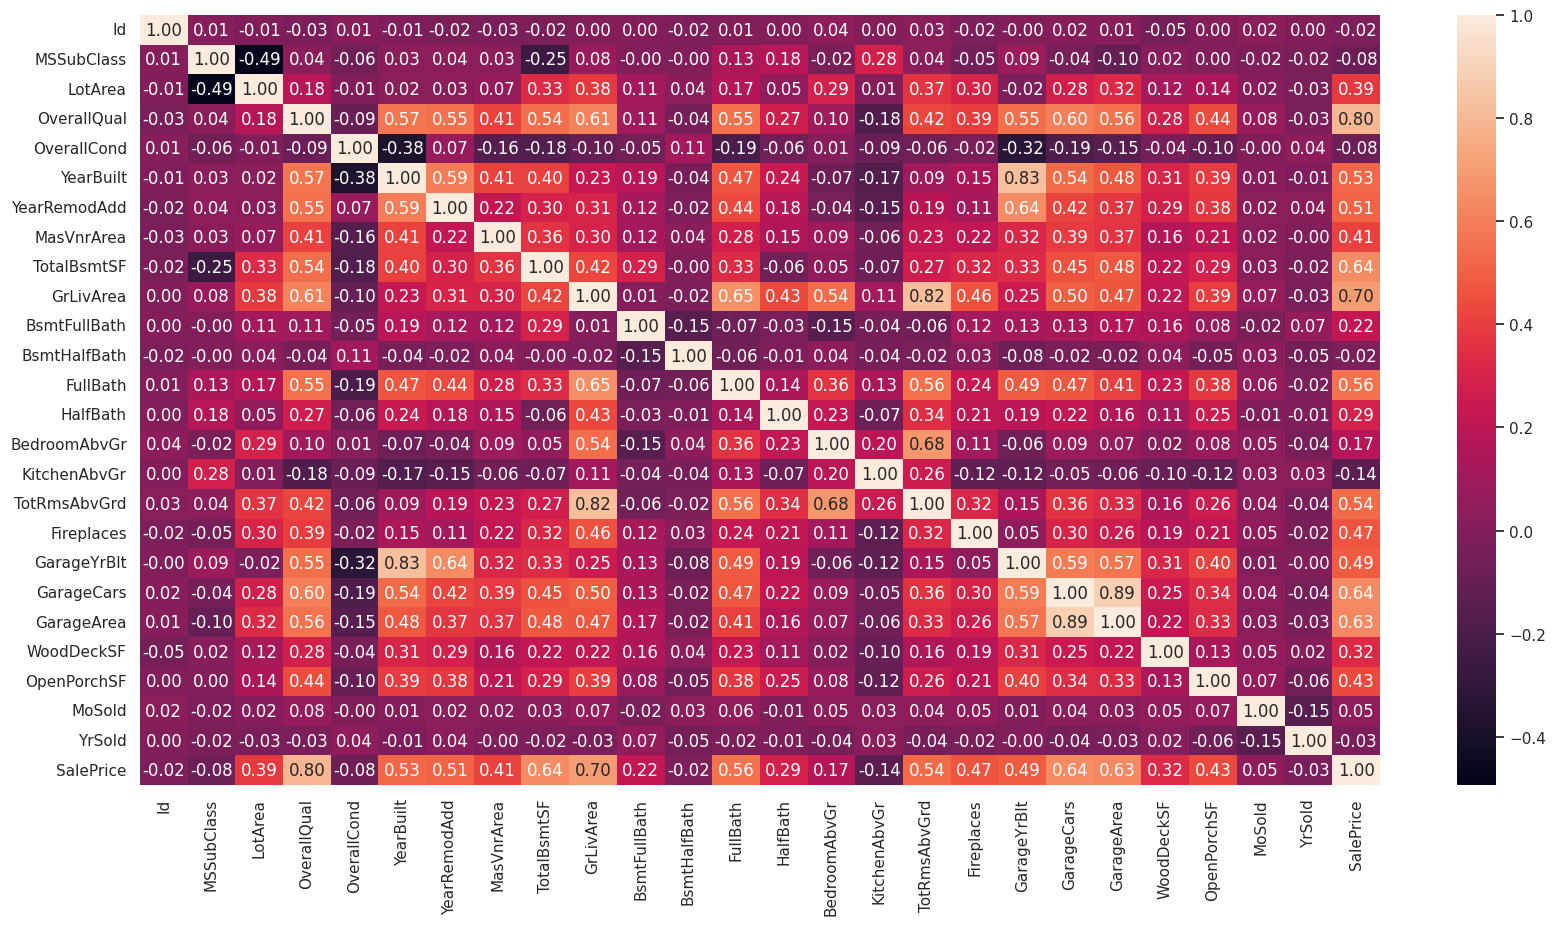

In [358]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train.corr(numeric_only=True),annot=True, fmt=".2f")
plt.show()

Observations:
- Low Correlation Columns - 'Id','OverallCond','MoSold','YrSold'.
- Even though MSSubClass have low correlation I will still keep it as low corr may be due to high cardinality.
- We can perform feature engineering and convert [BsmtFullBath + FullBath] to TotalFullBath and [BsmtHalfBath + HalfBath] to TotalHalfBath. #### Columns with Multicollinearity :
- GarageYrBlt - YearBuilt
- TotRmsAbvGrd - GrLivArea
- GarageArea - GarageCars From These above Columns we will keep which have better correlation with TargetColumn -'SalePrice'. #### Columns to drop:
- 'Id','OverallCond','MoSold','YrSold','GarageYrBlt', 'TotRmsAbvGrd','GarageArea'
- After Feature Engineering - BsmtFullBath , FullBath , BsmtHalfBath , HalfBath

In [360]:
### Feature Engineering
TotalFullBaths = df_train['FullBath'] + df_train['BsmtFullBath']
TotalFullBaths = TotalFullBaths.rename('TotalFullBaths')
TotalHalfBaths = df_train['HalfBath'] + df_train['BsmtHalfBath']
TotalHalfBaths = TotalHalfBaths.rename('TotalHalfBaths')

In [361]:
cols_remove = ['Id','OverallCond','MoSold','YrSold','GarageYrBlt', 'TotRmsAbvGrd','GarageArea','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath']
df_train.drop(columns=cols_remove,inplace =True)
removed_cols += cols_remove

In [362]:
num_cols.remove('GarageArea')

In [363]:
df_train.insert(loc=0,column='TotalFullBath',value=TotalFullBaths)
df_train.insert(loc=0,column='TotalHalfBath',value=TotalHalfBaths)

Conclusions after investigations:
- MasVnrType have nan where no masonary work is done so we will fill it Notav and see if it is useful column.
- Similarty FireplaceQu have missing value where there are no Fire place so will fill it with Notav.
- Similarly in Garage Columns and Basement Columns with notav
- At location 948 BsmtExposure need to be filled with No as Bsmt is Unfinished by looking at data.
- Drop that single row with empty electical value.
- Similarly at location 332 BsmtFinType2 need to be filled with Unf.

In [365]:
miss_perc = (df_train.isnull().sum()/len(df_train)).sort_values(ascending=False) * 100
miss_perc[miss_perc > 0]

MasVnrType      59.793814
FireplaceQu     47.422680
GarageFinish     5.567010
GarageCond       5.567010
GarageQual       5.567010
GarageType       5.567010
BsmtExposure     2.611684
BsmtFinType2     2.611684
BsmtFinType1     2.542955
BsmtCond         2.542955
BsmtQual         2.542955
MasVnrArea       0.549828
Electrical       0.068729
dtype: float64

In [366]:
df_train['BsmtExposure'].loc[948] = 'No'
df_train['BsmtFinType2'].loc[332] = 'Unf'

In [367]:
df_train[df_train['Electrical'].isna()].index

Index([1379], dtype='int64')

In [368]:
df_train.drop(1379,inplace = True)

In [369]:
df_train['MasVnrArea'].fillna(value=0.0,inplace=True)

In [370]:
for i in ['GarageCond','GarageType','GarageFinish','GarageQual','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType','FireplaceQu']:
    df_train[i].fillna(value = 'Notav',inplace = True)

Columns with Object Datatype

In [372]:
obj_cols = list(df_train.select_dtypes(include='object').columns)
print(obj_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


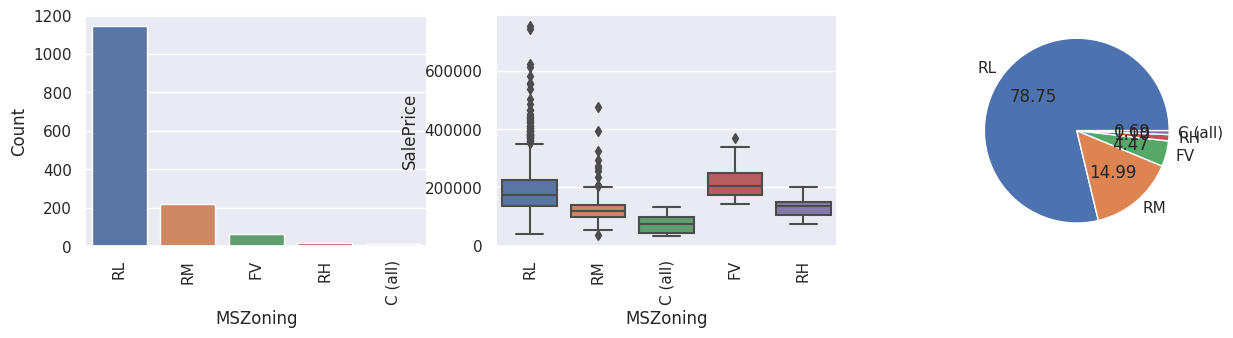

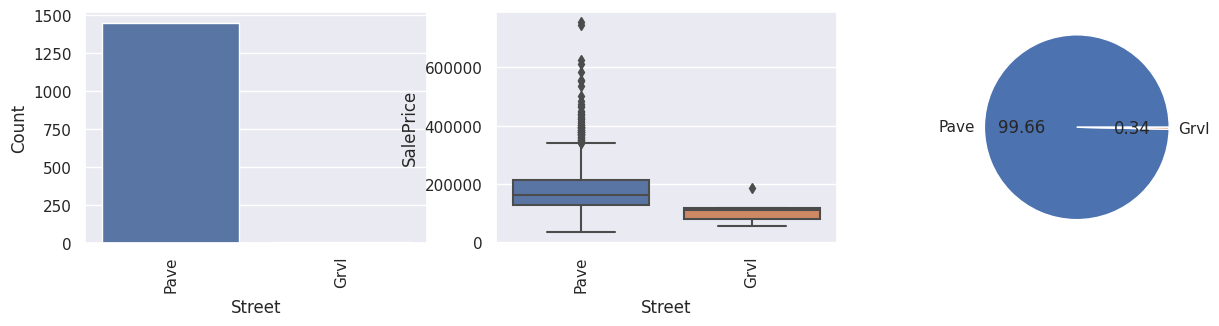

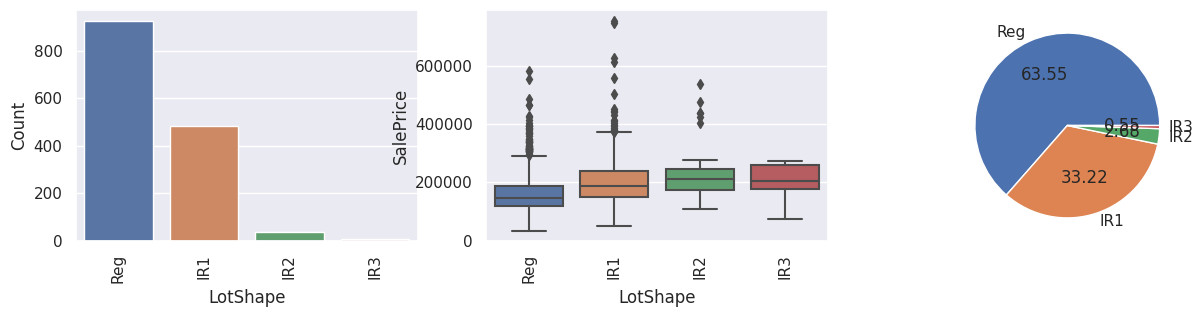

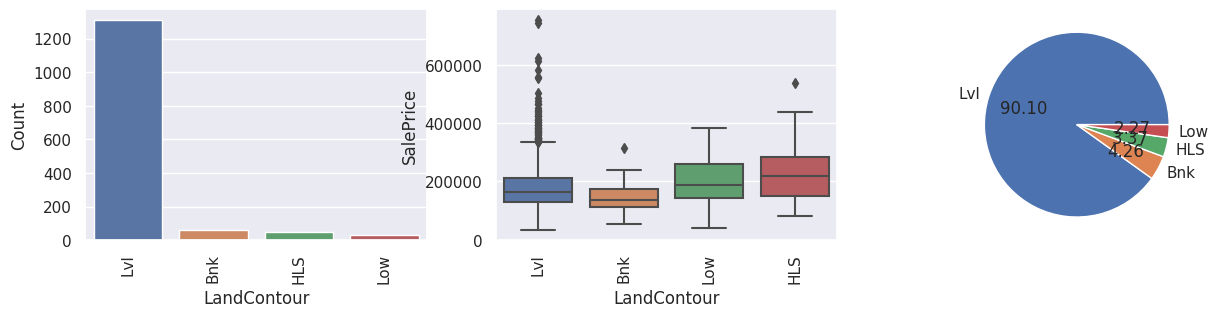

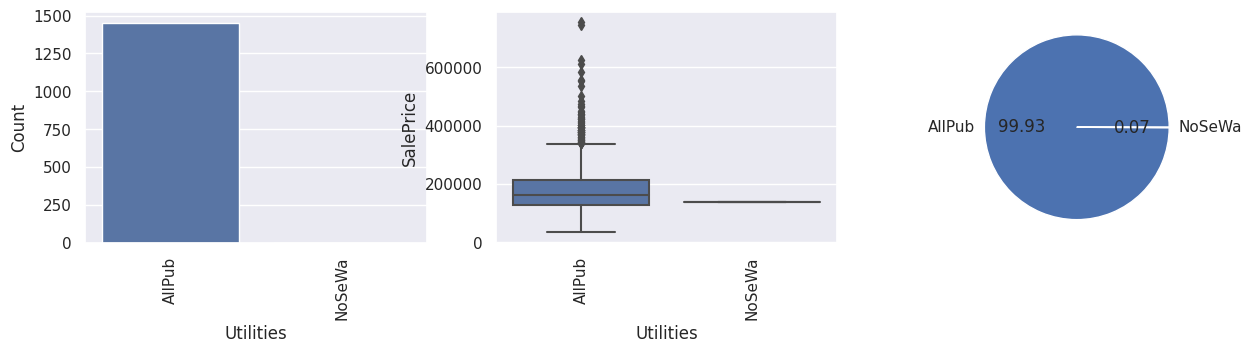

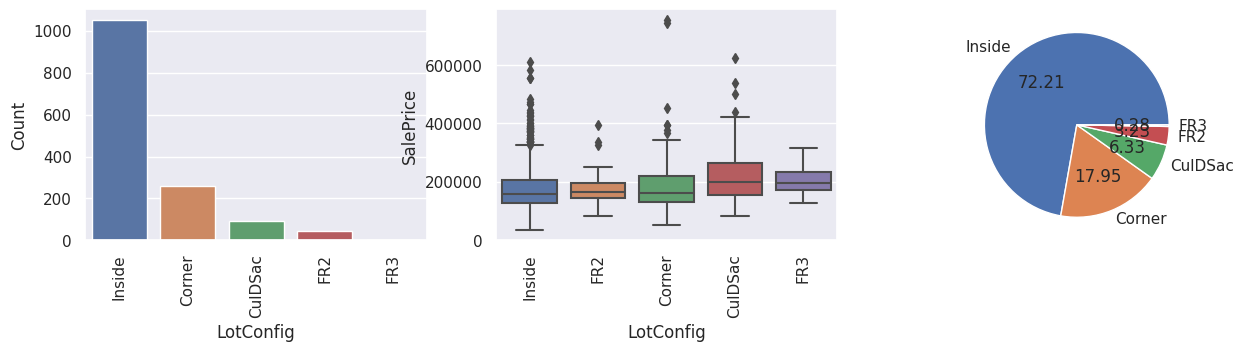

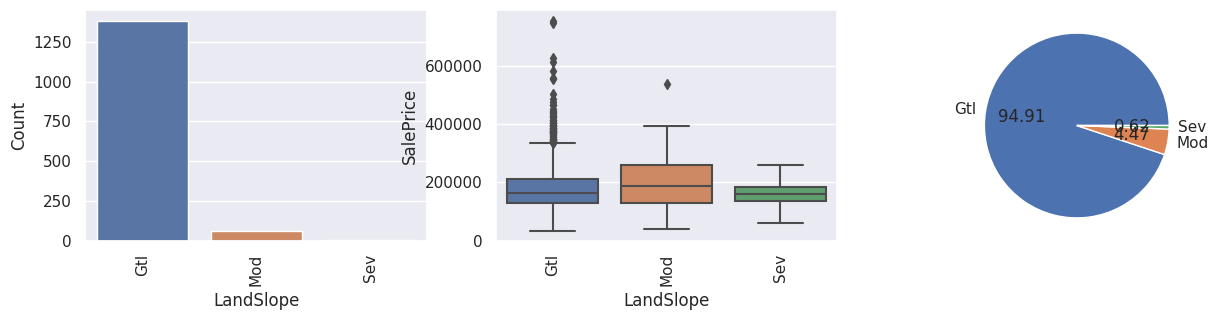

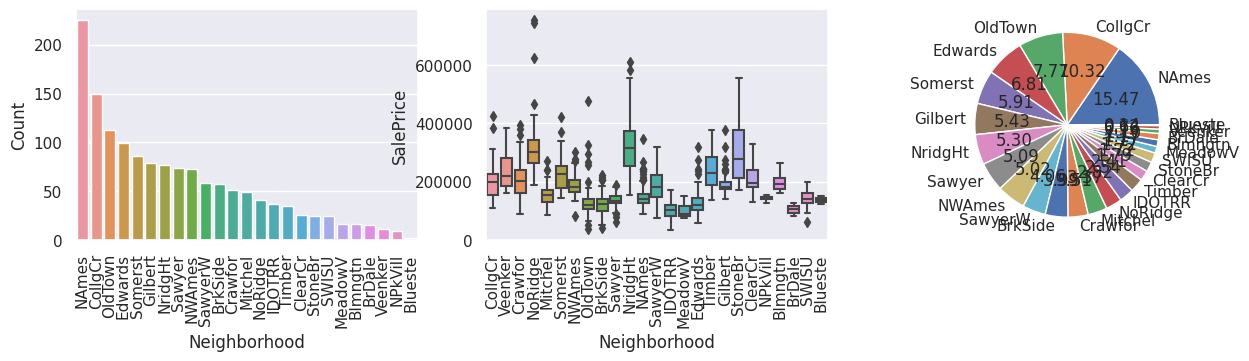

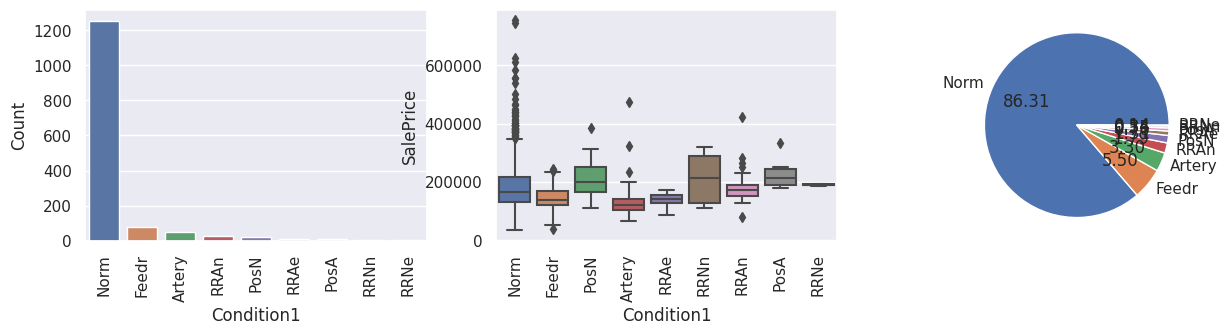

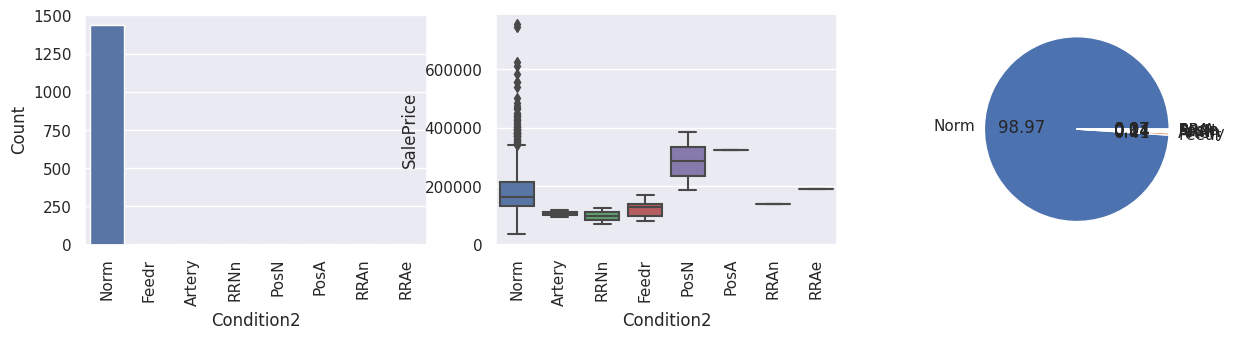

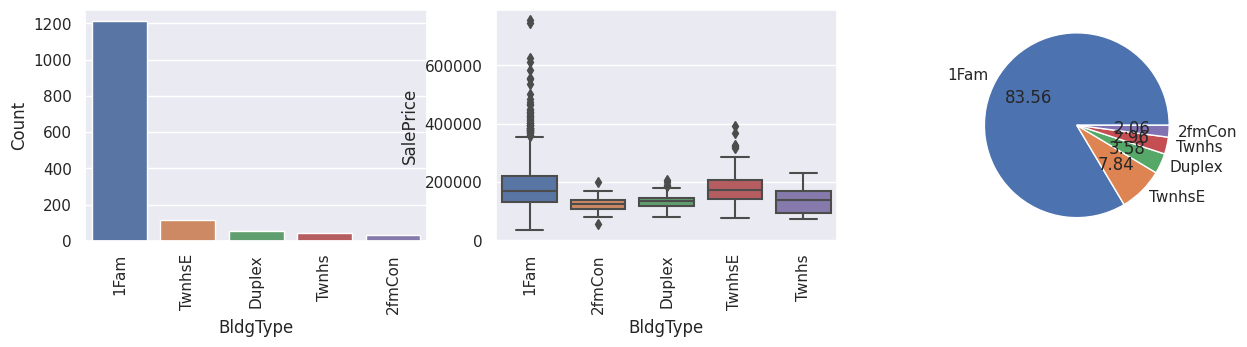

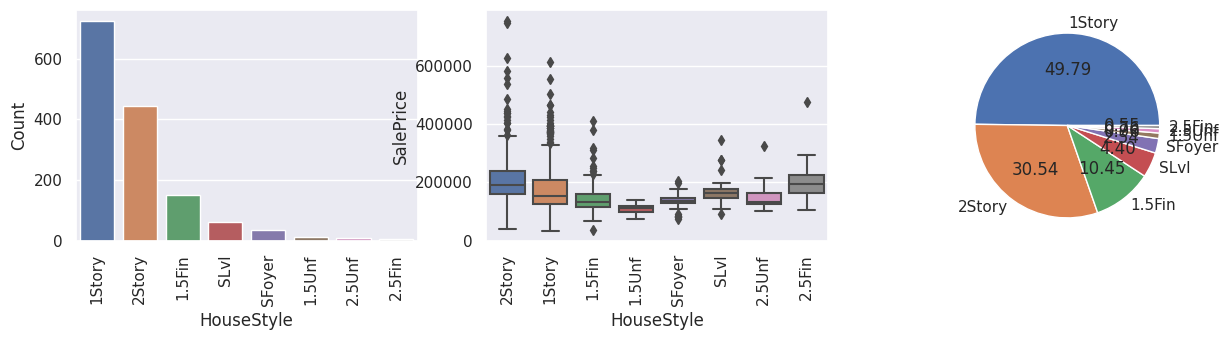

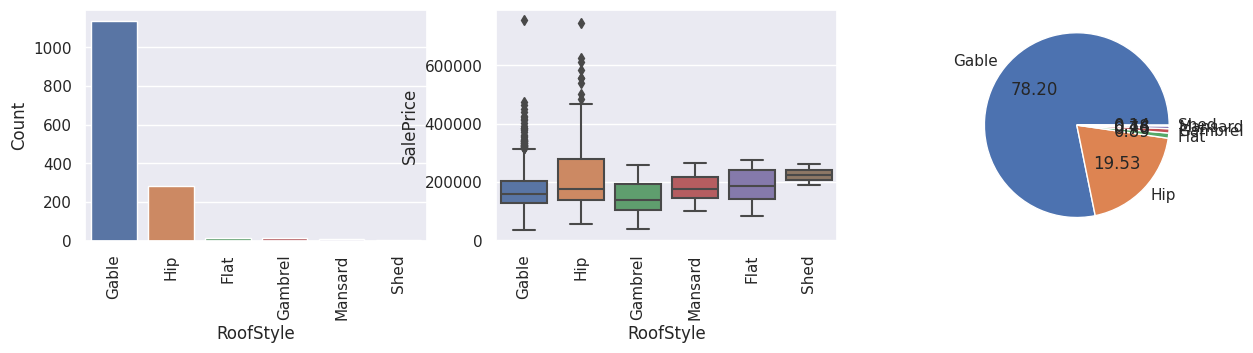

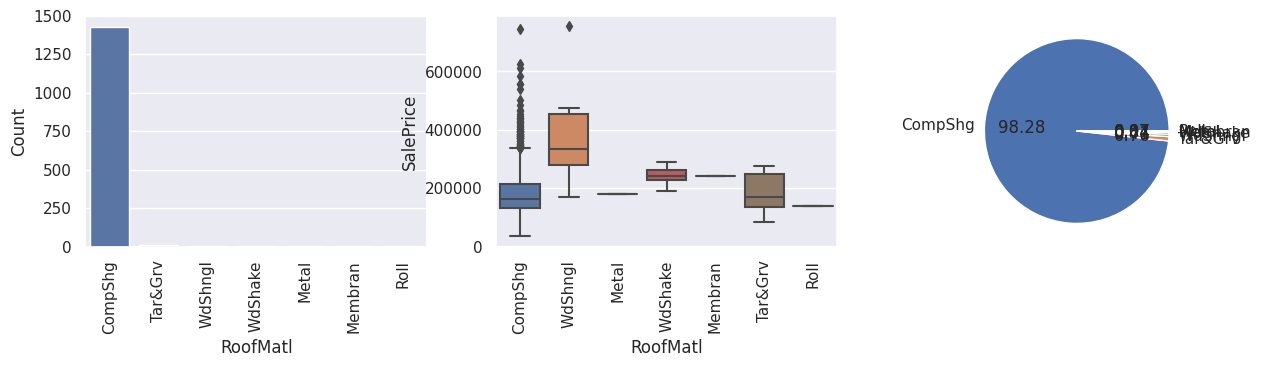

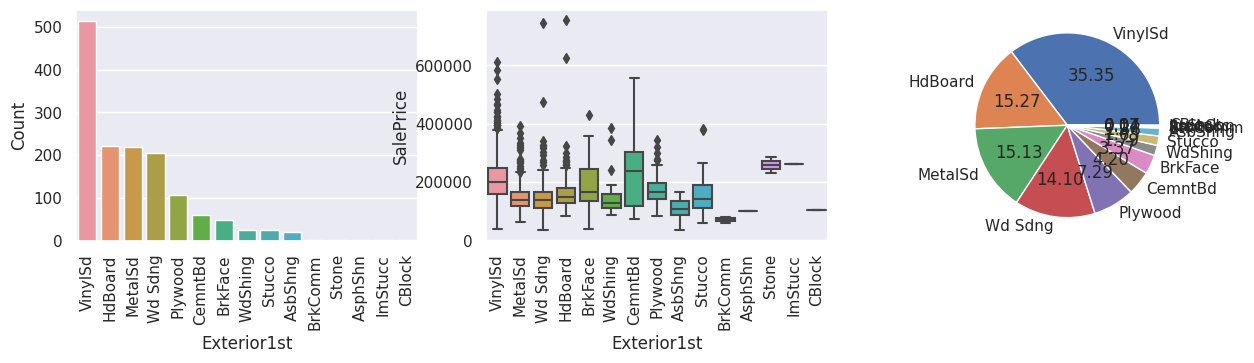

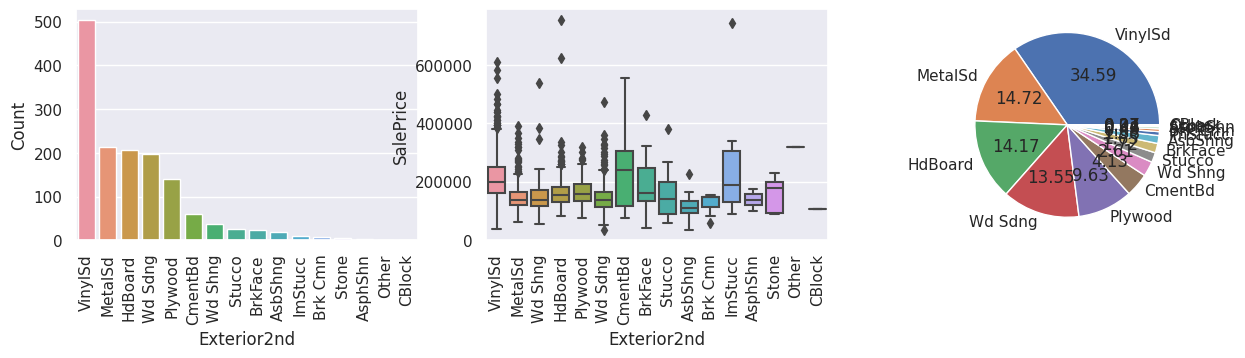

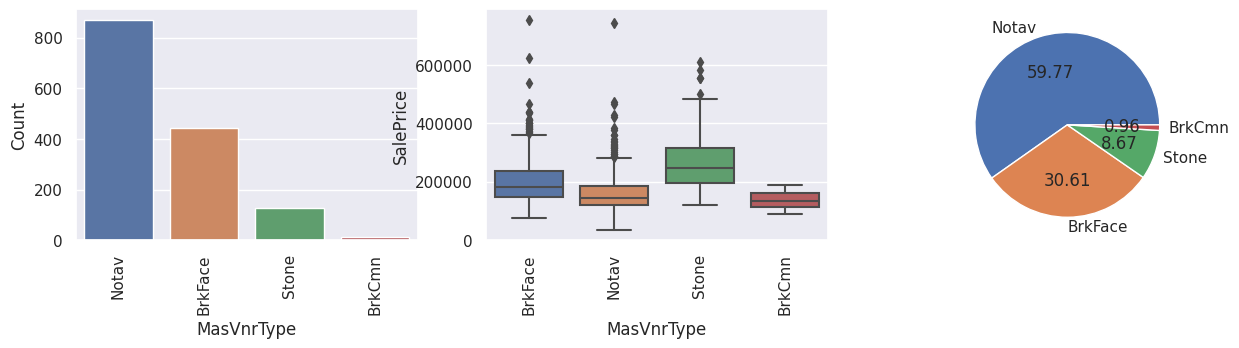

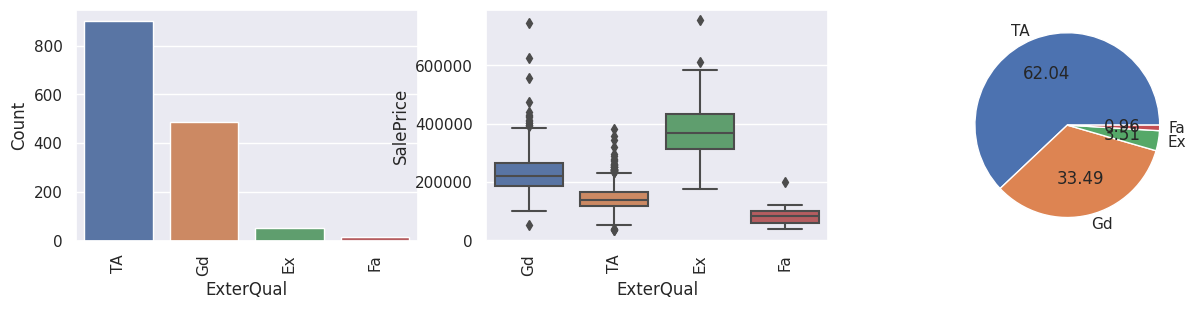

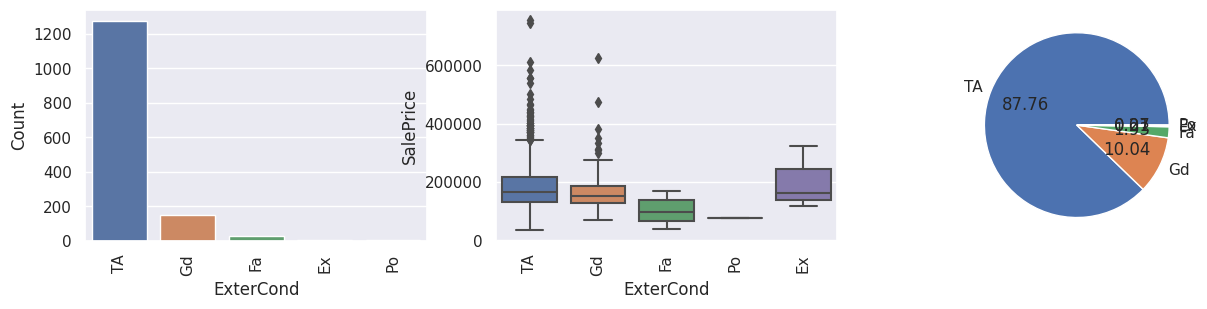

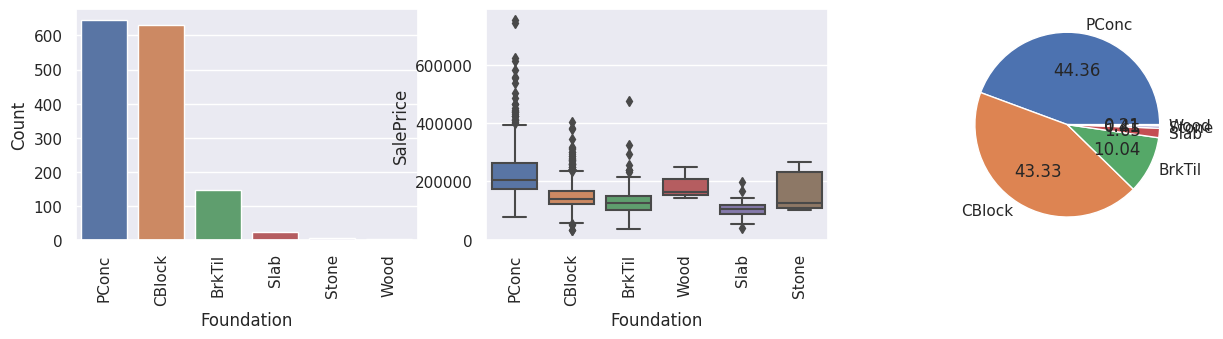

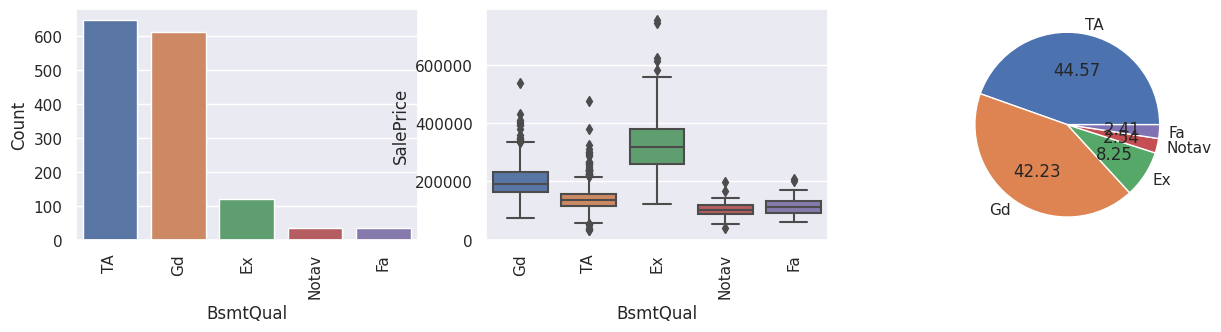

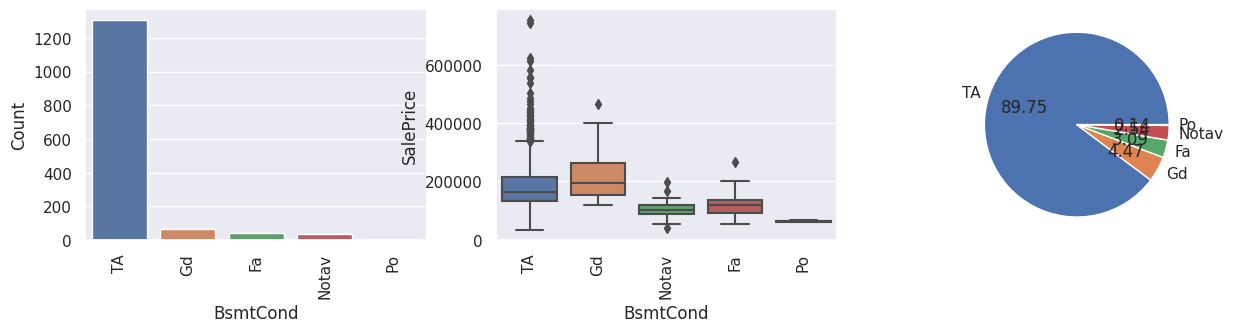

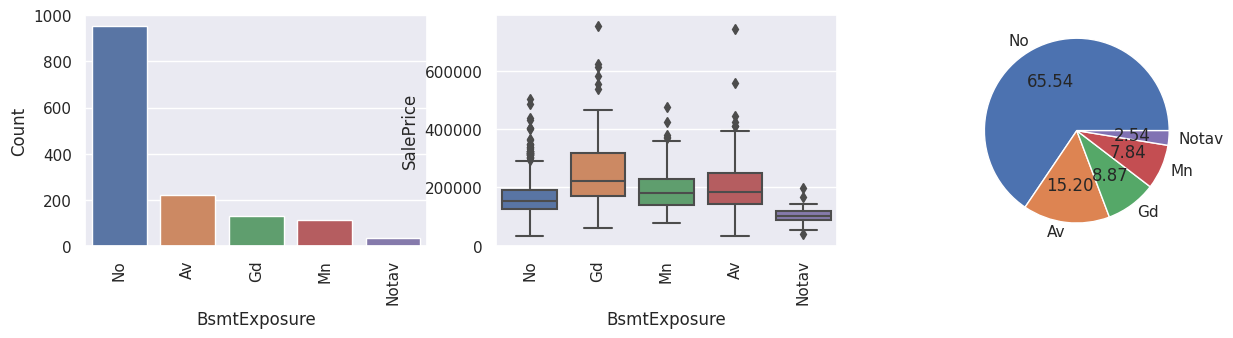

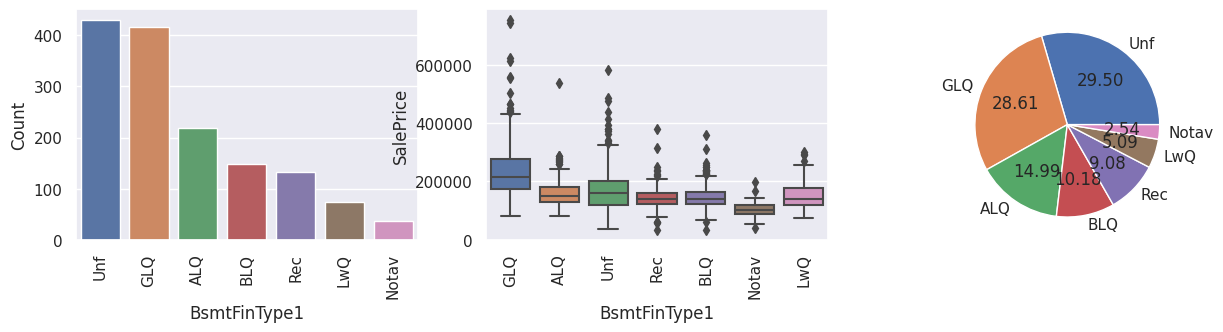

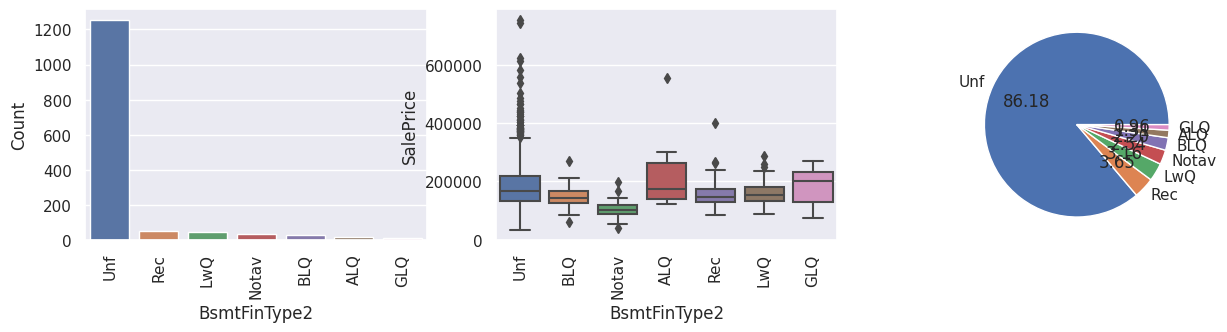

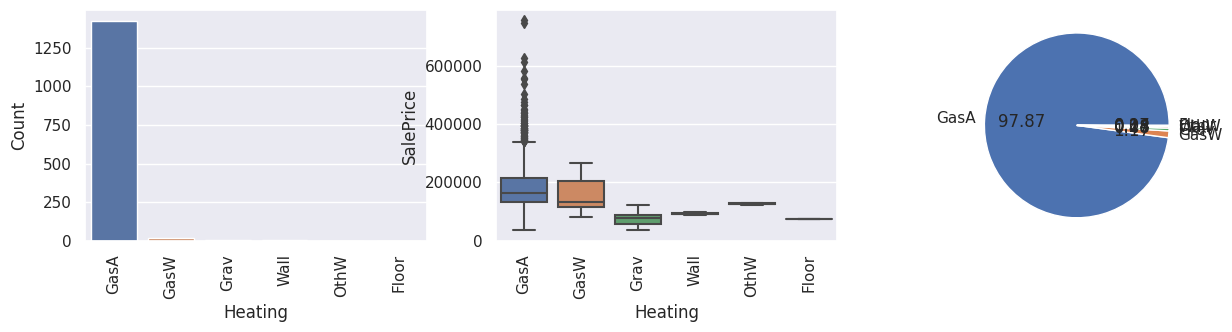

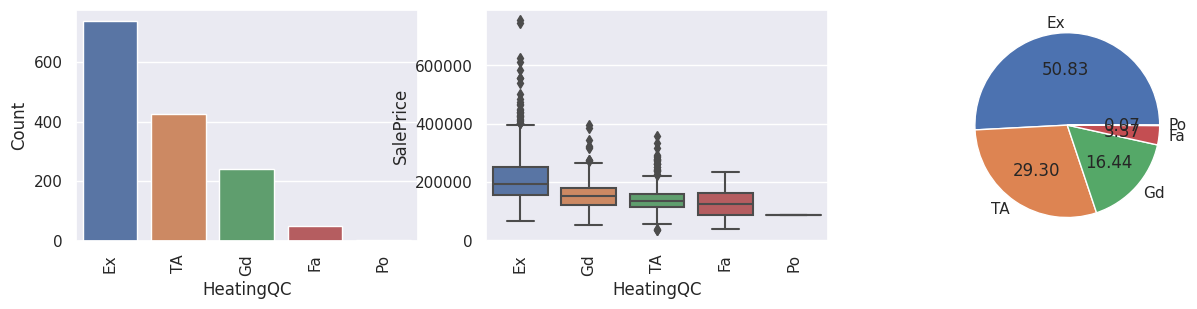

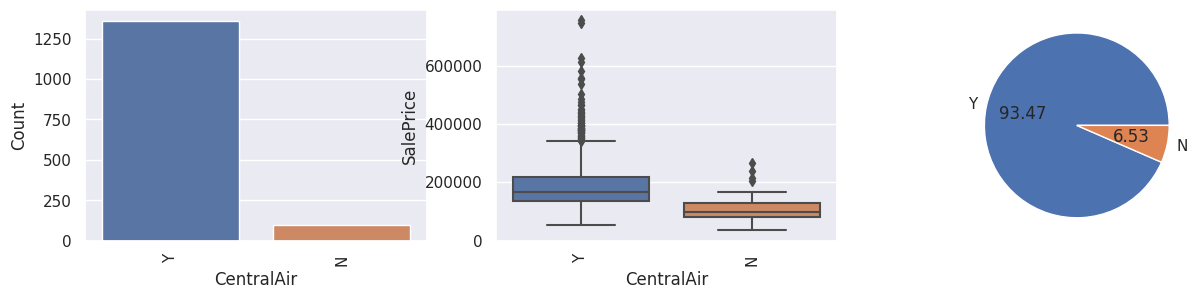

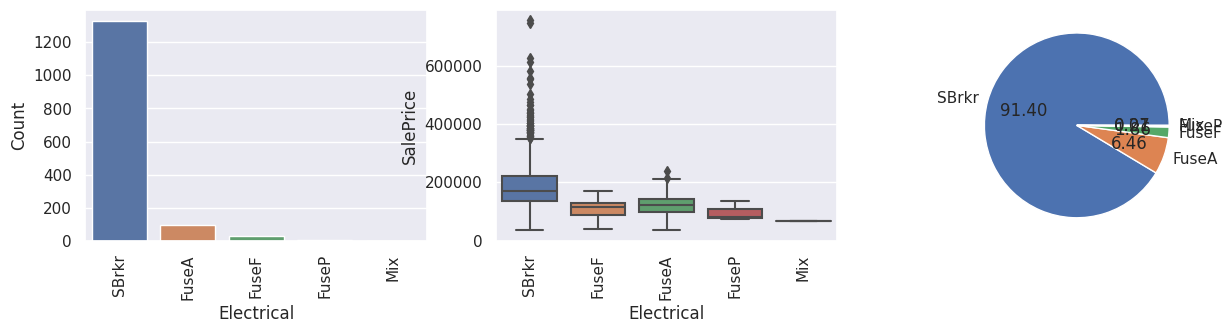

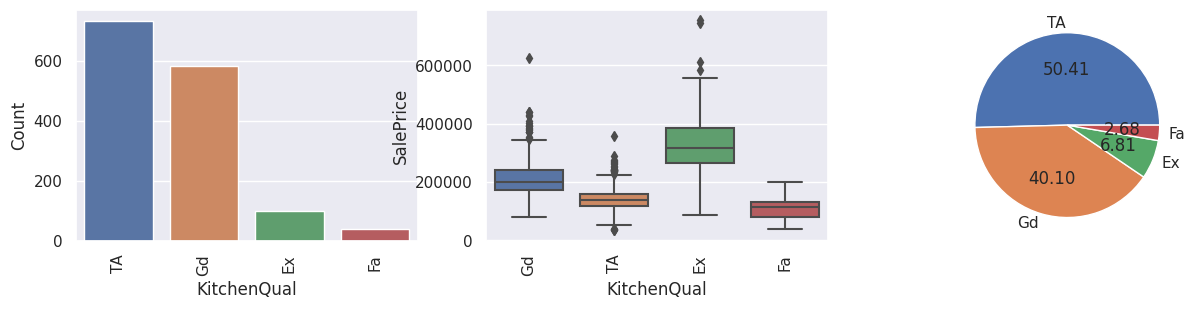

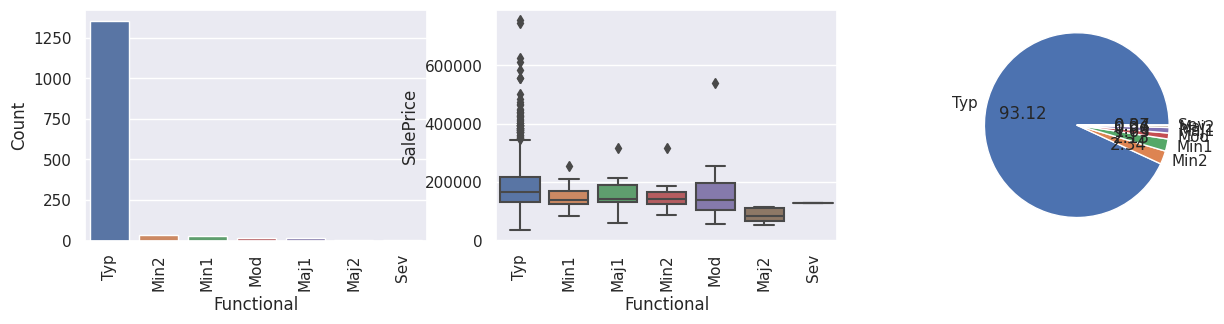

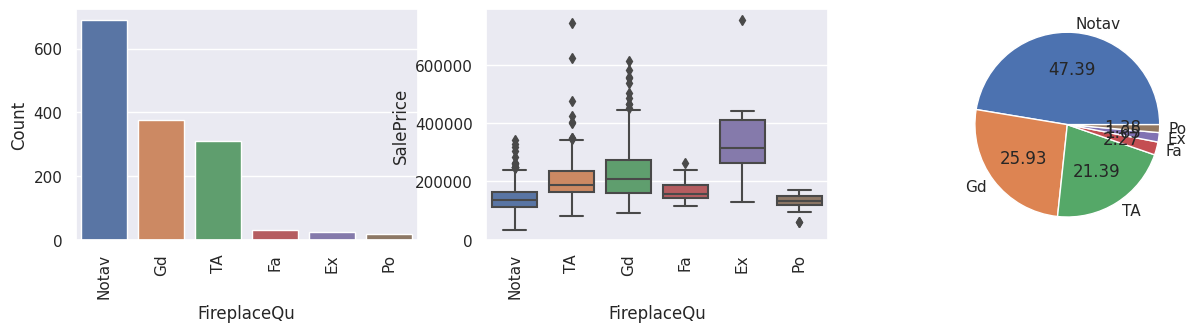

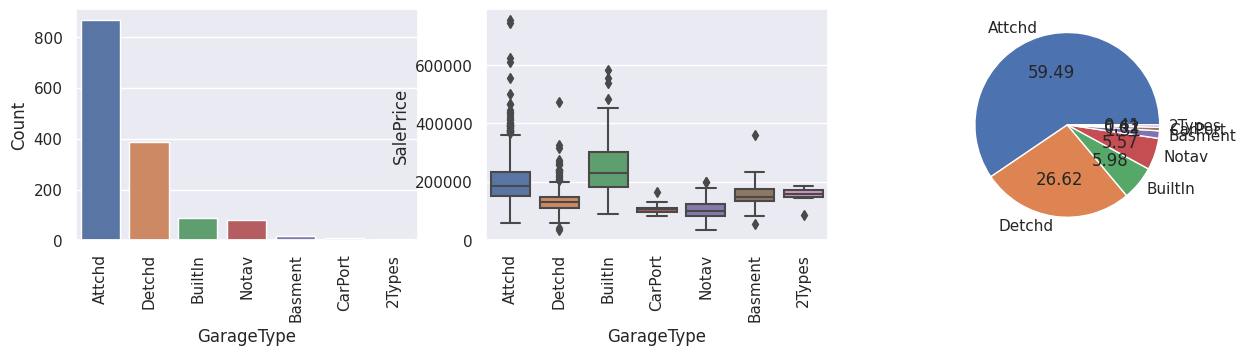

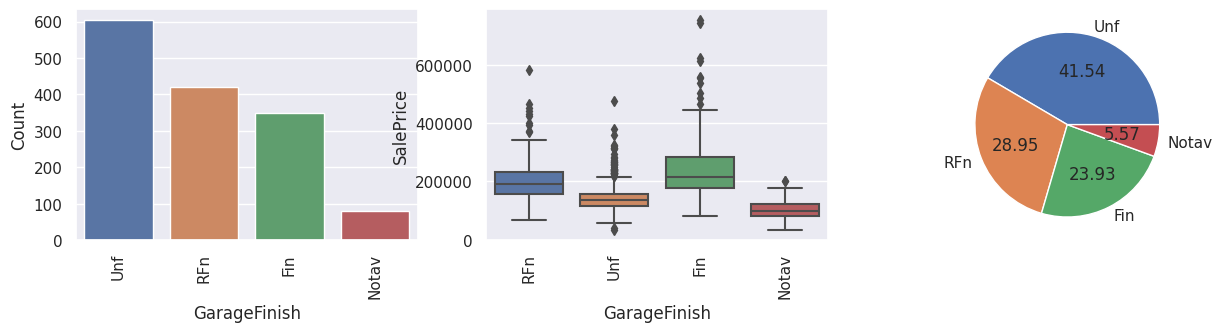

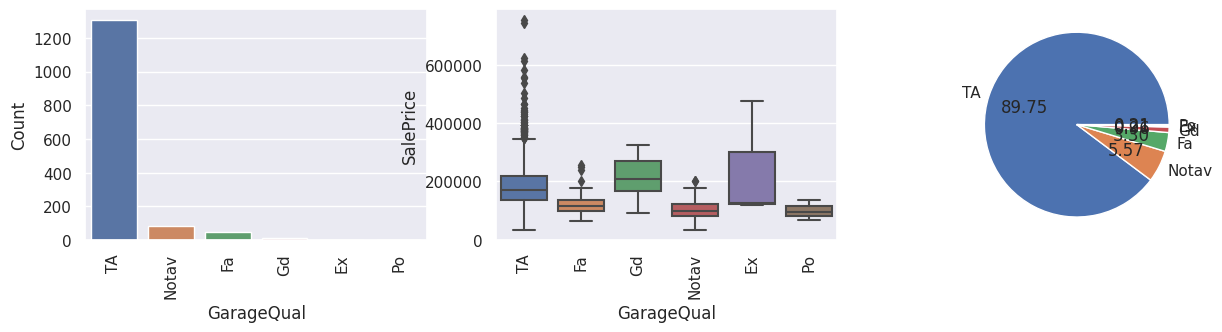

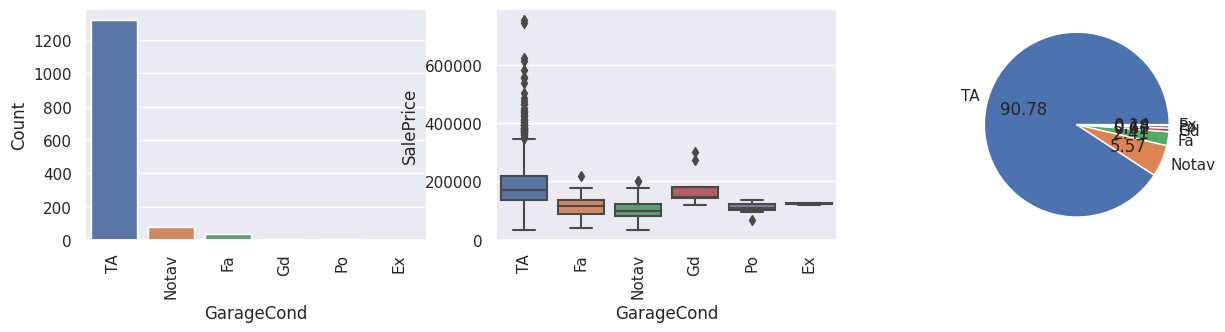

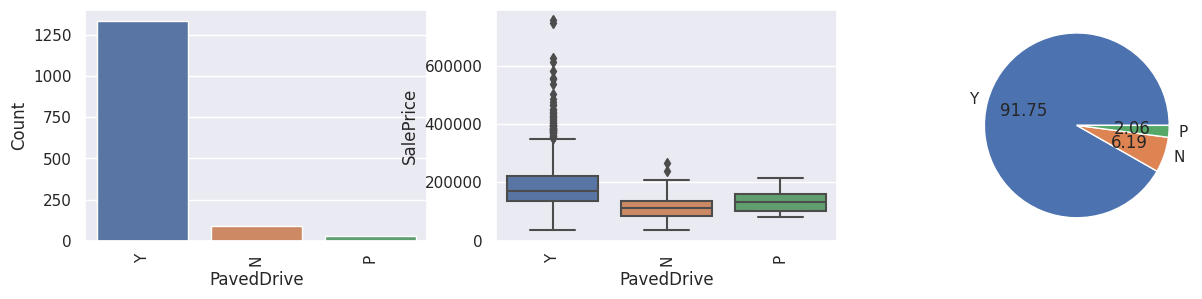

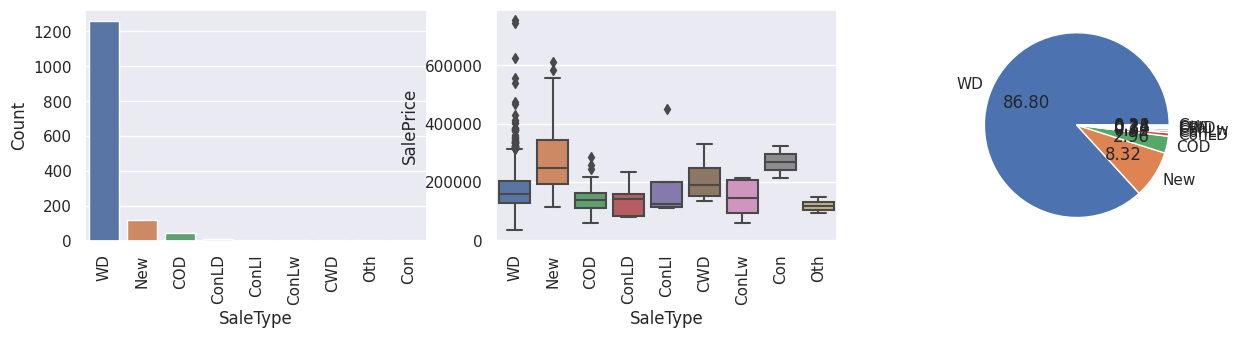

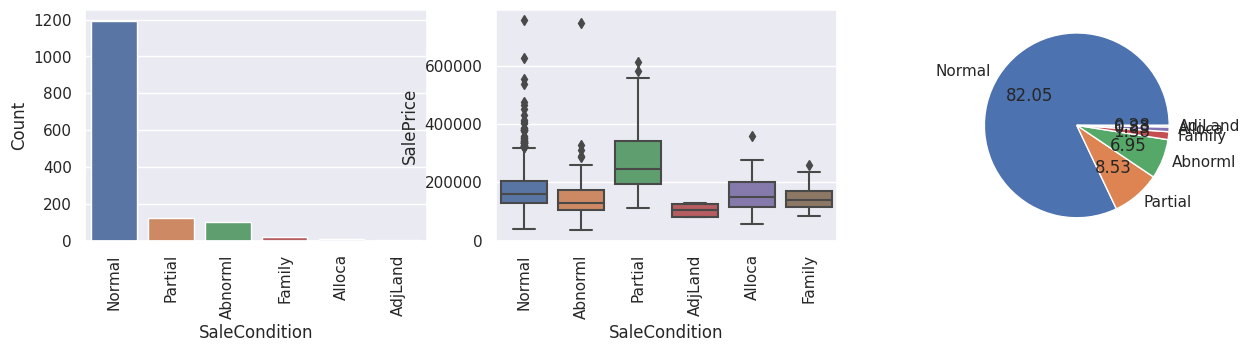

In [374]:
bar_box_pie_plot(obj_cols,df_train)

Observation

- There are multiple Columns which are heavily imbalanced. But we will not blindly remove such columns as models might still find these columns valuable.So we will use Random Forest Feature Importance to filter out unwanted columns.

- Let's Categorize data on basis of ordinal and nominal Form.

Ordinal Columns :
Quality and condition Columns with categories as ['Notav','Po','Fa','TA','Gd','Ex']:

- 'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FirplaceQu','GarageQual','GarageCond'.

Other ordinal Columns:

- 'BsmtExposure','PavedDrive','GarageType','GarageFinish', 'LotShape'

Rest are nominal

Random Forest Feature Importance
We will use ordinal encoding to encode our categorical data.

Since we will be using tree based models, ordinal encoding wont have much effect whether data is ordinal or nominal.

But We will still handle ordinal data according to their rank.

In [380]:
qual_cond_categories = [['Notav','Po','Fa','TA','Gd','Ex']]
qual_cond_list = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']
othr_odn_list = ['BsmtExposure','PavedDrive','GarageType','GarageFinish','LotShape']
othr_odn_cat = [['Notav','No','Mn','Av','Gd'],['N','P','Y'],['Notav','CarPort','Detchd','Basment','2Types','Attchd','BuiltIn'],
                ['Notav','Unf','RFn','Fin'],['IR3','IR2','IR1','Reg']]
rem_cols = obj_cols[:]
for i in ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','BsmtExposure','PavedDrive','GarageType','GarageFinish','LotShape']:
    rem_cols.remove(i)

In [381]:
transformer = ColumnTransformer(
    [('qual_cond_tnf',OrdinalEncoder(categories=qual_cond_categories * len(qual_cond_list)),qual_cond_list),
     ('othr_odn',OrdinalEncoder(categories = othr_odn_cat),othr_odn_list),
     ('rem_cols',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),rem_cols)],
    remainder='passthrough'
)

In [383]:
temp_df = df_train.reset_index(drop=True).copy()

X = temp_df[obj_cols][:]
y = temp_df.iloc[:,-1]

tnf_cols = qual_cond_list + othr_odn_list + rem_cols

X_tnf = pd.DataFrame(transformer.fit_transform(X),columns=tnf_cols)
temp_df[tnf_cols] = X_tnf

temp_df

TotalHalfBath  TotalFullBath  MSSubClass  MSZoning   LotArea  Street  \
0                 1              3          60       3.0  9.042040     1.0   
1                 1              2          20       3.0  9.169623     1.0   
2                 1              3          60       3.0  9.328212     1.0   
3                 0              2          70       3.0  9.164401     1.0   
4                 1              3          60       3.0  9.565284     1.0   
...             ...            ...         ...       ...       ...     ...   
1449              1              2          60       3.0  8.976894     1.0   
1450              0              3          20       3.0  9.486152     1.0   
1451              0              2          70       3.0  9.109746     1.0   
1452              0              2          20       3.0  9.181735     1.0   
1453              1              2          20       3.0  9.204121     1.0   

      LotShape  LandContour  Utilities  LotConfig  ...  GarageFinish  \
0          3.0          3.0        0.0        4.0  ...           2.0   
1          3.0          3.0        0.0        2.0  ...           2.0   
2          2.0          3.0        0.0        4.0  ...           2.0   
3          2.0          3.0        0.0        0.0  ...           1.0   
4          2.0          3.0        0.0        2.0  ...           2.0   
...        ...          ...        ...        ...  ...           ...   
1449       3.0          3.0        0.0        4.0  ...           2.0   
1450       3.0          3.0        0.0        4.0  ...           1.0   
1451       3.0          3.0        0.0        4.0  ...           2.0   
1452       3.0          3.0        0.0        4.0  ...           1.0   
1453       3.0          3.0        0.0        4.0  ...           3.0   

      GarageCars  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  \
0              2         3.0         3.0         2.0    0.000000     4.127134   
1              2         3.0         3.0         2.0    5.700444     0.000000   
2              2         3.0         3.0         2.0    0.000000     3.761200   
3              3         3.0         3.0         2.0    0.000000     3.583519   
4              3         3.0         3.0         2.0    5.262690     4.442651   
...          ...         ...         ...         ...         ...          ...   
1449           2         3.0         3.0         2.0    0.000000     3.713572   
1450           2         3.0         3.0         2.0    5.857933     0.000000   
1451           1         3.0         3.0         2.0    0.000000     4.110874   
1452           1         3.0         3.0         2.0    5.905362     0.000000   
1453           1         3.0         3.0         2.0    6.602588     4.234107   

      SaleType  SaleCondition  SalePrice  
0          8.0            4.0     208500  
1          8.0            4.0     181500  
2          8.0            4.0     223500  
3          8.0            0.0     140000  
4          8.0            4.0     250000  
...        ...            ...        ...  
1449       8.0            4.0     175000  
1450       8.0            4.0     210000  
1451       8.0            4.0     266500  
1452       8.0            4.0     142125  
1453       8.0            4.0     147500  

[1454 rows x 56 columns]

In [384]:
X = temp_df.iloc[:,:-1]
y = temp_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X,y)
fi = rf.feature_importances_

fi_df = pd.DataFrame(list(zip(X.columns,fi *100))).sort_values(by=1,ascending=False).reset_index(drop=True)
fi_df

0             1
0     OverallQual  6.069058e+01
1       GrLivArea  1.361097e+01
2     TotalBsmtSF  6.674322e+00
3         LotArea  1.720973e+00
4      GarageCars  1.522965e+00
5      MasVnrArea  1.427245e+00
6       YearBuilt  1.426035e+00
7    YearRemodAdd  1.165853e+00
8    Neighborhood  7.921245e-01
9   TotalFullBath  7.548693e-01
10     WoodDeckSF  6.840000e-01
11    KitchenQual  6.425250e-01
12     GarageType  6.414025e-01
13       BsmtQual  6.389038e-01
14    OpenPorchSF  6.373178e-01
15    FireplaceQu  5.406167e-01
16   BsmtFinType1  5.332791e-01
17   GarageFinish  4.671879e-01
18   BsmtExposure  4.180475e-01
19   BedroomAbvGr  3.625076e-01
20  SaleCondition  3.539528e-01
21     CentralAir  3.129285e-01
22    Exterior1st  2.886602e-01
23      LotConfig  2.830349e-01
24     Fireplaces  2.681744e-01
25       MSZoning  2.558141e-01
26       LotShape  2.356731e-01
27  TotalHalfBath  2.306154e-01
28    Exterior2nd  2.302418e-01
29     MasVnrType  2.256780e-01
30      ExterQual  2.158423e-01
31     MSSubClass  1.975518e-01
32    LandContour  1.380603e-01
33       SaleType  1.321616e-01
34      RoofStyle  1.114143e-01
35     GarageQual  1.105821e-01
36     HouseStyle  1.006112e-01
37      ExterCond  9.849419e-02
38     Functional  9.523557e-02
39      HeatingQC  8.883165e-02
40       BsmtCond  8.195913e-02
41     Condition1  7.562323e-02
42     Condition2  6.609320e-02
43     Foundation  6.358500e-02
44   KitchenAbvGr  6.234722e-02
45   BsmtFinType2  6.131387e-02
46      LandSlope  6.062572e-02
47     GarageCond  5.779150e-02
48     PavedDrive  4.822741e-02
49       BldgType  3.523208e-02
50       RoofMatl  3.200450e-02
51     Electrical  2.467510e-02
52        Heating  4.741445e-03
53         Street  4.890173e-04
54      Utilities  6.352588e-07

In [385]:
temp_df.drop(columns = ['Street','Utilities'],inplace = True)

Base Model:

We will use Tree Based models. But you can also use Linear models or any other models.

- Linear models will perform worse in our current form of data since we have used ordinal encoding for all categorical columns.
- Here we will Use XGBoost and GradientBoosting.

In [386]:
pipe_xgb = Pipeline([('scaler', StandardScaler()), ('xgbr',XGBRegressor())])
pipe_gbm = Pipeline([('scaler', StandardScaler()),('gbm',GradientBoostingRegressor())])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['r2', 'neg_root_mean_squared_error']

In [388]:
## XGBoostRegressor
xgb_scores = cross_validate(pipe_xgb, X, y, cv=kf, scoring=scoring,return_train_score = True)
print(f"R2: {np.mean(xgb_scores['test_r2']):.4f} ± {np.std(xgb_scores['test_r2']):.4f}")
print(f"RMSE: {-np.mean(xgb_scores['test_neg_root_mean_squared_error']):.4f} ± {np.std(xgb_scores['test_neg_root_mean_squared_error']):.4f}")

R2: 0.8497 ± 0.0391
RMSE: 30361.0446 ± 3468.0089


In [389]:
# Gradient Boosting
gbm_scores = cross_validate(pipe_gbm, X, y, cv=kf, scoring=scoring,return_train_score = True)
print(f"R2: {np.mean(gbm_scores['test_r2']):.4f} ± {np.std(gbm_scores['test_r2']):.4f}")
print(f"RMSE: {-np.mean(gbm_scores['test_neg_root_mean_squared_error']):.4f} ± {np.std(gbm_scores['test_neg_root_mean_squared_error']):.4f}")

R2: 0.8571 ± 0.0633
RMSE: 29244.4423 ± 5817.7896


HyperParameter Tuning:

For Hyperparameter Tuning we can use GridSearchCV or RandomizedSearchCV.
But here I will do hyperparameter tuning according to my knowledge.

In [390]:
pipe_xgb = Pipeline([('scaler', StandardScaler()), ('xgbr',XGBRegressor(tree_method="hist", device="cuda",eta=0.1,max_depth = 4,alpha = 0.31,min_child_weight=3,subsample=0.6))])
pipe_gbm = Pipeline([('scaler', StandardScaler()),('gbm',GradientBoostingRegressor(max_depth=3,n_estimators=200,alpha=0.8,max_leaf_nodes=6,learning_rate=0.1))])

In [391]:
## XGBoostRegressor
xgb_scores = cross_validate(pipe_xgb, X, y, cv=kf, scoring=scoring,return_train_score = True)
print(f"R2: {np.mean(xgb_scores['test_r2']):.4f} ± {np.std(xgb_scores['test_r2']):.4f}")
print(f"RMSE: {-np.mean(xgb_scores['test_neg_root_mean_squared_error']):.4f} ± {np.std(xgb_scores['test_neg_root_mean_squared_error']):.4f}")

R2: 0.8638 ± 0.0633
RMSE: 28502.7557 ± 5840.3976


In [392]:
# Gradient Boosting
gbm_scores = cross_validate(pipe_gbm, X, y, cv=kf, scoring=scoring,return_train_score = True)
print(f"R2: {np.mean(gbm_scores['test_r2']):.4f} ± {np.std(gbm_scores['test_r2']):.4f}")
print(f"RMSE: {-np.mean(gbm_scores['test_neg_root_mean_squared_error']):.4f} ± {np.std(gbm_scores['test_neg_root_mean_squared_error']):.4f}")

R2: 0.8621 ± 0.0625
RMSE: 28675.4270 ± 5852.4725


XGBoost is better after Hyperparameter Tuning. So we will use XGBRegressor.

Model Creation
We will create proper sklearn ml pipelines which will perform data preprocessing, encoding, scaling, predictions.

In [393]:
main_feat= list(temp_df.columns)
main_feat.remove('TotalHalfBath')
main_feat.remove('TotalFullBath')
for i in ['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath']:
    main_feat.append(i)
main_feat.remove('SalePrice')

In [394]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [395]:
train_df.drop(outliers_rows,inplace = True)
train_df['BsmtExposure'].loc[948] = 'No'
train_df['BsmtFinType2'].loc[332] = 'Unf'
train_df.drop(1379,inplace = True)

In [396]:
class preprocess_df(BaseEstimator, TransformerMixin):
    def fit(self,X,y):
        return self

    def transform(self,X):
        tnf_df = self.dropper(X)
        tnf_df = self.imputer(tnf_df)
        tnf_df = self.feat_eng(tnf_df)
        tnf_df = self.log_tnf(tnf_df)
        return tnf_df

    def dropper(self,df):
        return df[main_feat][:]
        
    def imputer(self,df):
        ## fill columns with notav
        notav_cols = ['GarageCond','GarageType','GarageFinish','GarageQual','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType','FireplaceQu']
        for i in notav_cols:
            df[i].fillna(value = 'Notav',inplace = True)
        ## imputer zero in numerical columns
        num_cols = df.select_dtypes(include='number').columns
        for i in num_cols:
            df[i].fillna(value=0,inplace = True)
        obj_cols = df.select_dtypes(include='object').columns
        ## Fill categorical obj columns with most frequent(mode)
        for i in obj_cols:
            mod = df[i].mode()[0]
            df[i].fillna(value = mod,inplace = True)
        return df

    def feat_eng(self,df):
        TotalFullBaths = df['FullBath'][:] + df['BsmtFullBath'][:]
        TotalHalfBaths = df['HalfBath'][:] + df['BsmtHalfBath'][:]
        df.insert(loc=0,column='TotalFullBath',value=TotalFullBaths)
        df.insert(loc=0,column='TotalHalfBath',value=TotalHalfBaths)
        df.drop(columns=['FullBath','BsmtFullBath','HalfBath','BsmtHalfBath'],inplace = True)
        return df

    def log_tnf(self,df):
        for i in ['LotArea', 'GrLivArea', 'MasVnrArea','WoodDeckSF','OpenPorchSF']:
            df[i] = np.log1p(df[i])
        return df

In [399]:
rem_cols.remove('Street')
rem_cols.remove('Utilities')

In [400]:
odn_enc = ColumnTransformer(
    [('qual_cond_tnf',OrdinalEncoder(categories=qual_cond_categories * len(qual_cond_list)),qual_cond_list),
     ('othr_odn',OrdinalEncoder(categories = othr_odn_cat),othr_odn_list),
     ('rem_cols',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),rem_cols)],
    remainder='passthrough'
)

In [401]:
model = Pipeline(
    [('preprocesser',preprocess_df()),
    ('encoding',odn_enc),
    ('scaler',StandardScaler()),
    ('xgb_reg',XGBRegressor(tree_method="hist", device="cuda",eta=0.1,max_depth = 4,alpha = 0.31,min_child_weight=3,subsample=0.6))]    
)

In [402]:
X = train_df.iloc[:,:-1]
y = np.log1p(train_df['SalePrice'])

In [403]:
model.fit(X,y)

Pipeline(steps=[('preprocesser', preprocess_df()),
                ('encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('qual_cond_tnf',
                                                  OrdinalEncoder(categories=[['Notav',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Notav',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Notav',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Notav',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Notav',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Notav',
                                                                              'Po',...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, ...))])

In [404]:
## XGBoostRegressor
xgb_scores = cross_validate(model, X, y, cv=kf, scoring=scoring,return_train_score = True)
print(f"R2: {np.mean(xgb_scores['test_r2']):.4f} ± {np.std(xgb_scores['test_r2']):.4f}")
print(f"RMSE: {-np.mean(xgb_scores['test_neg_root_mean_squared_error']):.4f} ± {np.std(xgb_scores['test_neg_root_mean_squared_error']):.4f}")

R2: 0.8912 ± 0.0129
RMSE: 0.1310 ± 0.0052


In [407]:
ypreds = model.predict(df_test)

In [408]:
test_preds = np.expm1(ypreds)

In [411]:
test_id = df_test['Id'].values

In [412]:
submission = pd.DataFrame({'Id' : test_id, 'Saleprice': test_preds})

In [413]:
submission

Id      Saleprice
0     1461  120044.859375
1     1462  155732.296875
2     1463  178706.031250
3     1464  186929.046875
4     1465  190984.937500
...    ...            ...
1454  2915   78536.070312
1455  2916   74592.562500
1456  2917  147559.671875
1457  2918  124973.453125
1458  2919  223642.203125

[1459 rows x 2 columns]

In [414]:
submission.to_csv('submission.csv', index=False)

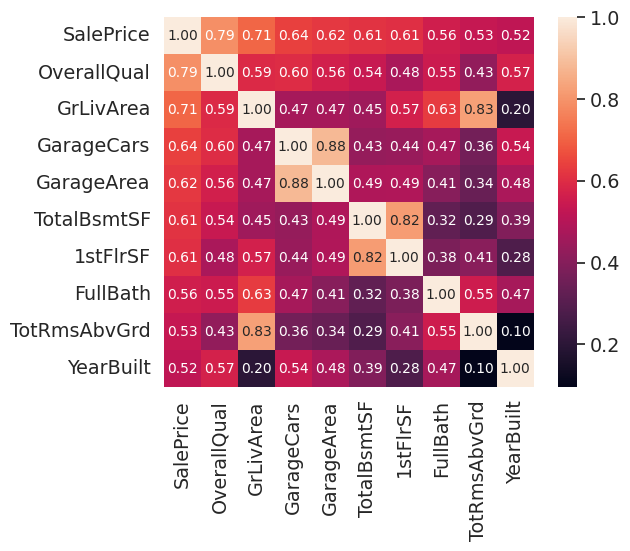

In [273]:
#saleprice correlation matrix
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm=np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels = cols.values)
plt.show()

At first sight, there are two white colored squares that get my attention. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'GarageX' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. 

Another thing that got my attention was the 'SalePrice' correlations. We can see our well-known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual', but we can also see many other variables that should be taken into account. That's what we will do next.

'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.

'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).

'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF'

'FullBath'?

'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.

It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right.

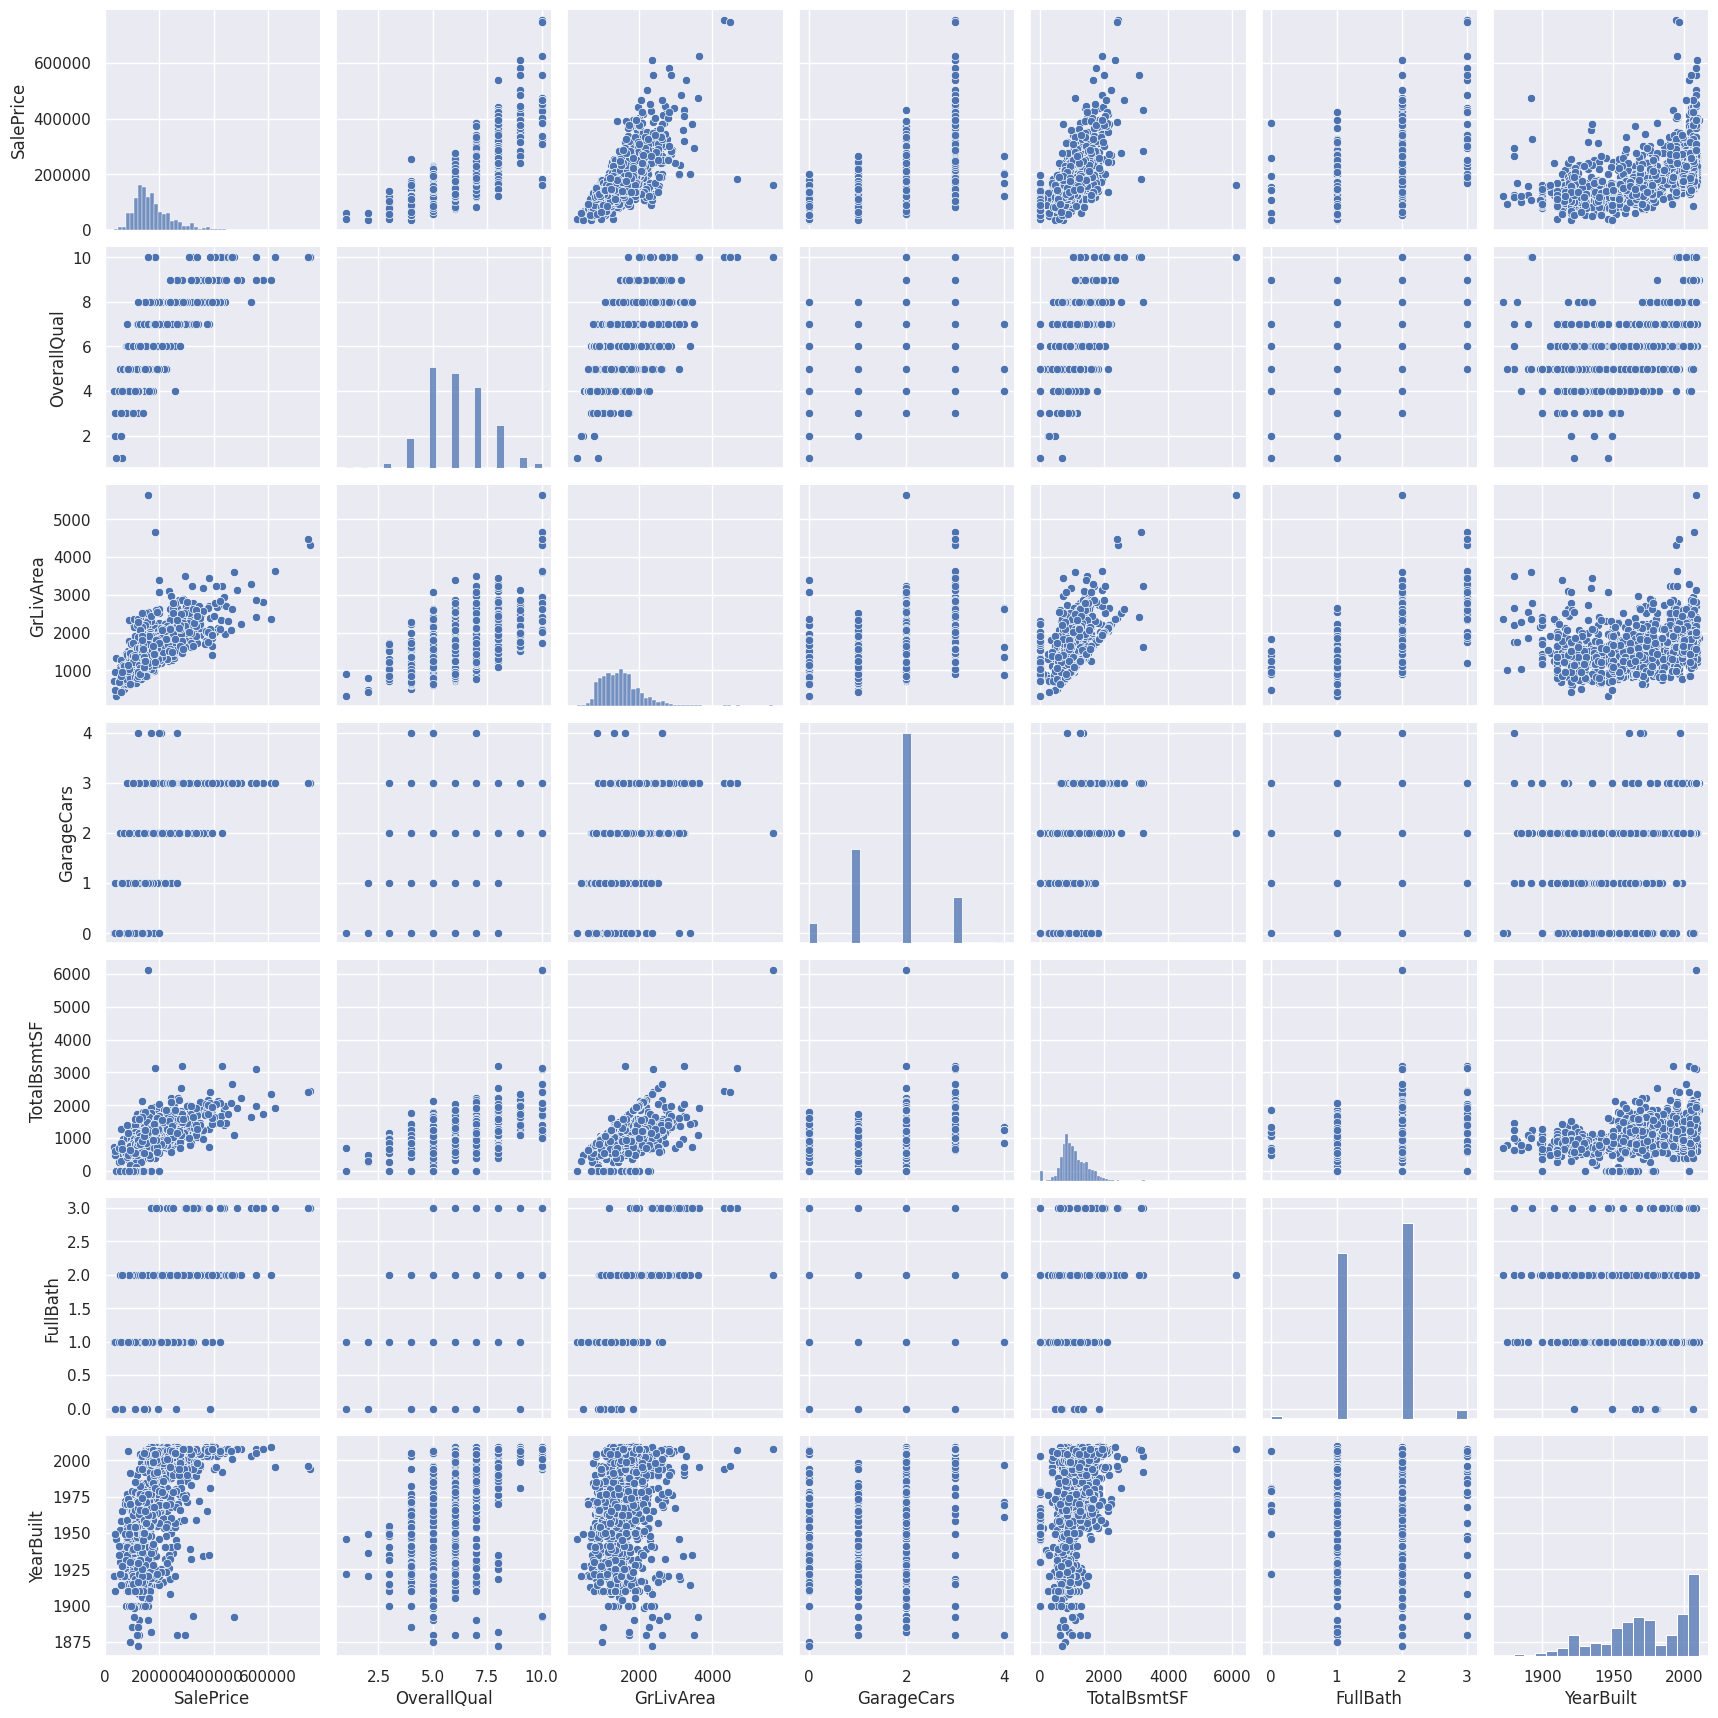

In [274]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size=2.5)
plt.show()

Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?
The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth

In [275]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
MasVnrType      872  0.597260
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
Electrical        1  0.000685
Id                0  0.000000

Let's analyse this to understand how to handle the missing data.

We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.

In what concerns the remaining cases, we can see that 'GarageX' variables have the same number of missing data. I bet missing data refers to the same set of observations (although I will not check it; it's just 5% and we should not spend 20 in5
  problems). Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete the mentioned 'GarageX' variables. The same logic applies to 'BsmtX' variables.

Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [276]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total']> 1]).index, axis=1)
df_test = df_test.drop((missing_data[missing_data['Total']>1]).index, axis=1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

In [277]:
#missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
MSZoning          4  0.002742
Functional        2  0.001371
BsmtFullBath      2  0.001371
BsmtHalfBath      2  0.001371
Utilities         2  0.001371
BsmtUnfSF         1  0.000685
BsmtFinSF2        1  0.000685
Exterior2nd       1  0.000685
GarageCars        1  0.000685
GarageArea        1  0.000685
BsmtFinSF1        1  0.000685
KitchenQual       1  0.000685
Exterior1st       1  0.000685
TotalBsmtSF       1  0.000685
SaleType          1  0.000685
HalfBath          0  0.000000
BedroomAbvGr      0  0.000000
FullBath          0  0.000000
KitchenAbvGr      0  0.000000
GrLivArea         0  0.000000

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [278]:
# standardizing data
# Convert the SalePrice column to a NumPy array and reshape it
saleprice_array = df_train['SalePrice'].values.reshape(-1, 1)

saleprice_scaled = StandardScaler().fit_transform(saleprice_array);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


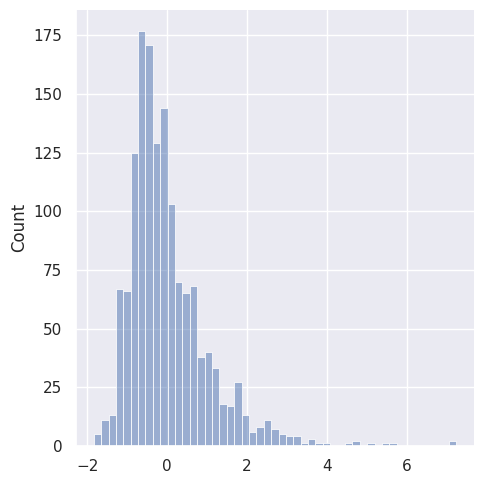

In [279]:
#histogram
sns.displot(saleprice_scaled, legend=False);

Low range values are similar and not too far from 0.
High range values are far from 0 and the 7.something values are really out of range.
For now, we'll not consider any of these values as an outlier but we should be careful with those two 7. something values.

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

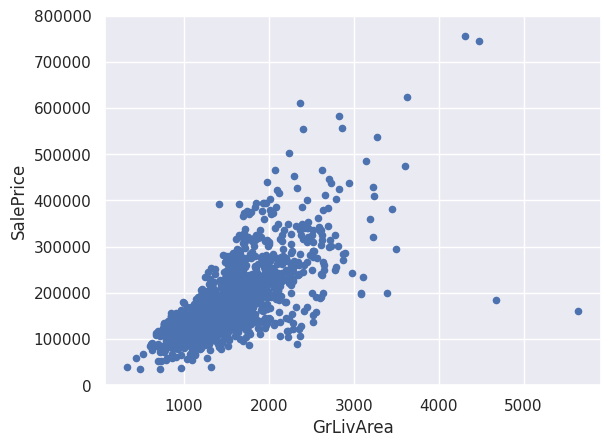

In [280]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

What has been revealed:

The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We can speculate why this is happening. Maybe they refer to agricultural area and that could explain the low price. I'm not sure about this but I'm quite confident that these two points are not representative of the typical case. 

Therefore, we'll define them as outliers and delete them.
The two observations in the top of the plot are those 7.something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [281]:
df_train.sort_values(by = 'GrLivArea', ascending=False)[:2]

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
1298  1299          60       RL    63887   Pave      IR3         Bnk   
523    524          60       RL    40094   Pave      IR1         Bnk   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
1298    AllPub    Corner       Gtl  ...             0         0           0   
523     AllPub    Inside       Gtl  ...             0         0           0   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
1298      480       0       1    2008       New        Partial    160000  
523         0       0      10    2007       New        Partial    184750  

[2 rows x 63 columns]

In [282]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

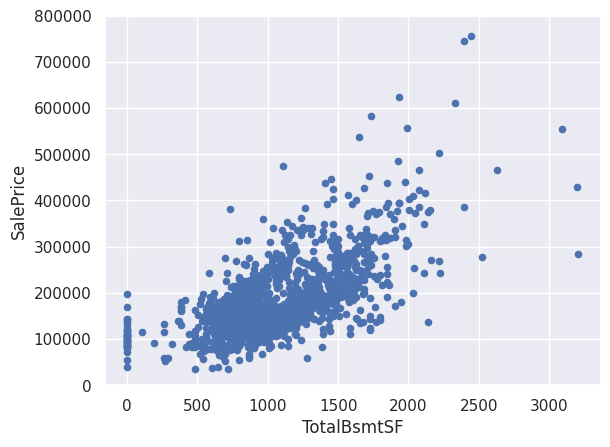

In [283]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000));

We already did some data cleaning and discovered a lot about 'SalePrice'. Now it's time to go deep and understand how 'SalePrice' complies with the statistical assumptions that enables us to apply multivariate techniques.

According to Hair et al. (2013), four assumptions should be tested:

Normality - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). We'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

Homoscedasticity - Refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

Linearity- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

Absence of correlated errors - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

- Histogram - Kurtosis and skewness.

- Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.


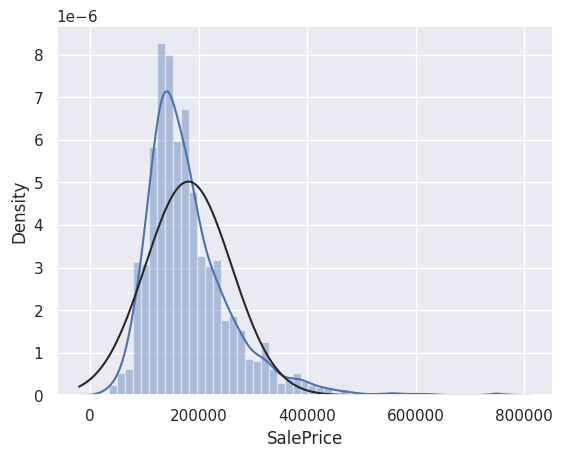

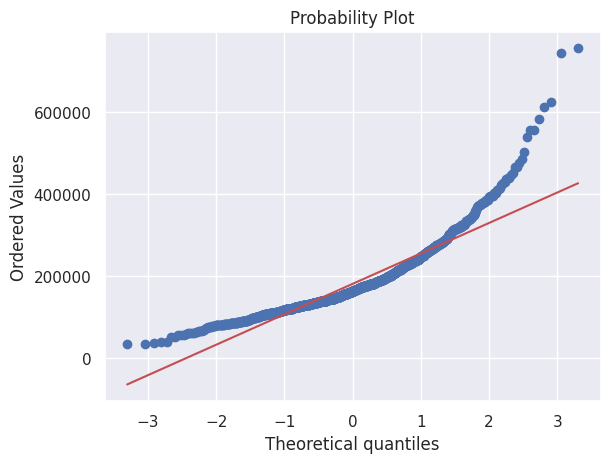

In [284]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res= stats.probplot(df_train['SalePrice'], plot=plt)

Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

A simple data transformation can solve the problem. In case of positive skewness, log transformations usually works well.

In [285]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

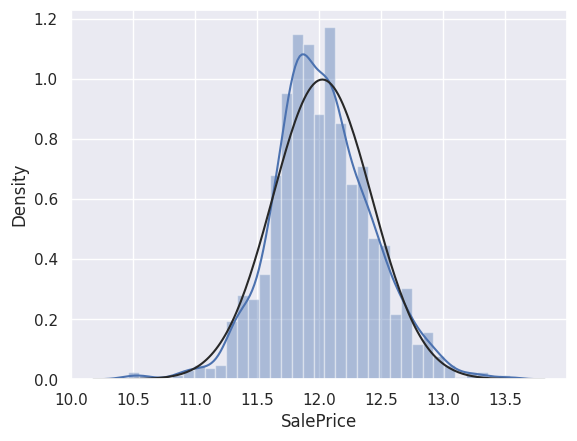

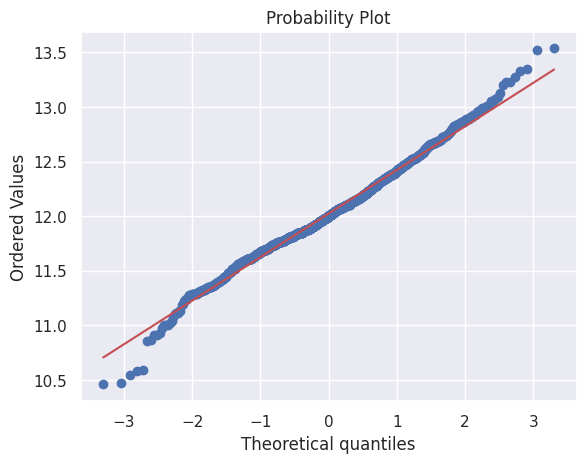

In [286]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

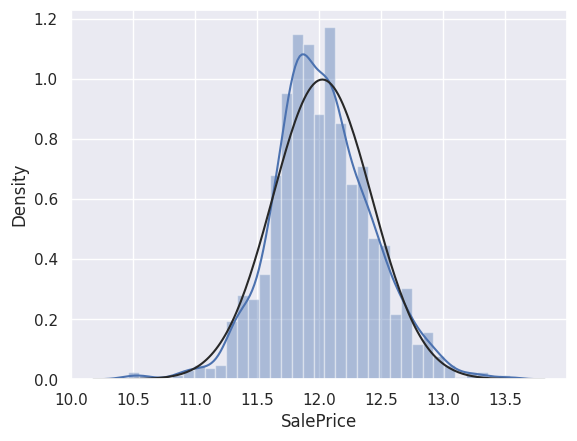

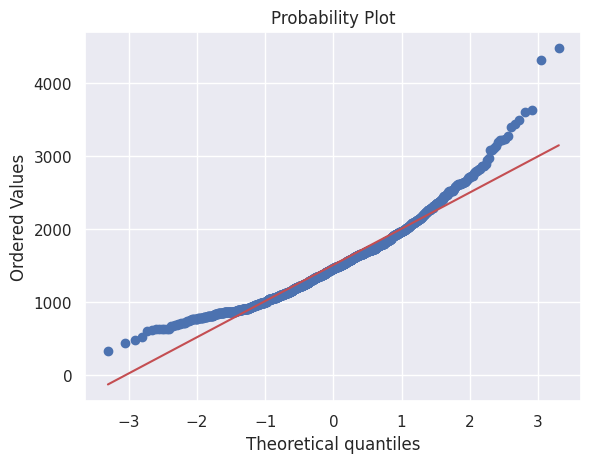

In [287]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [288]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

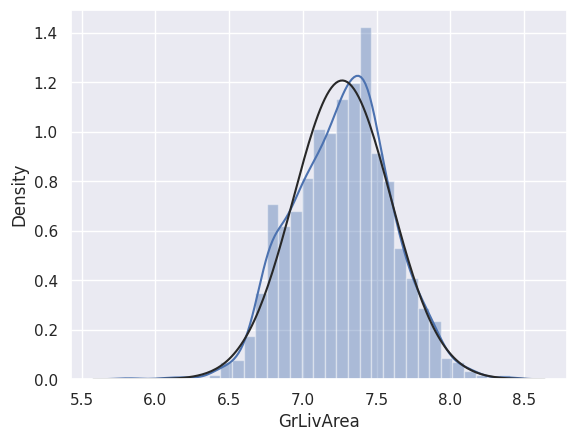

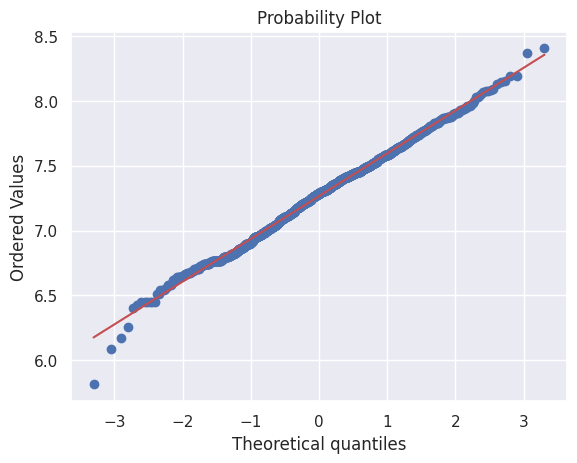

In [289]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot = plt)

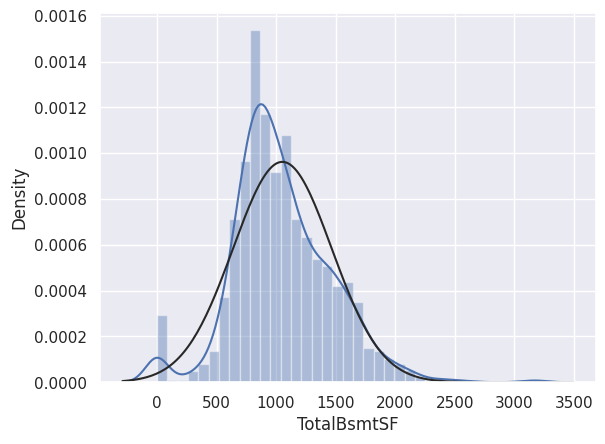

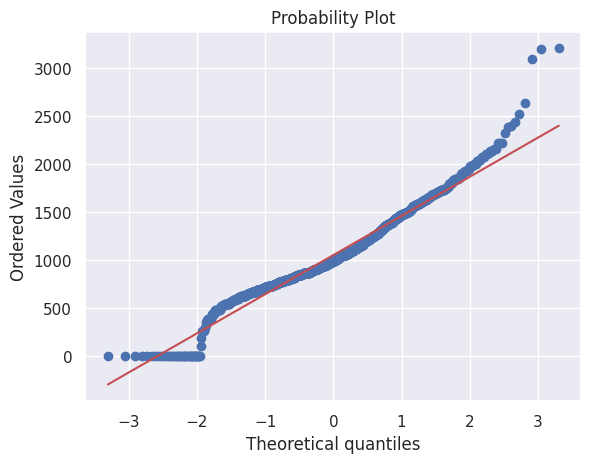

In [290]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot = plt)

- Something that, in general, presents skewness.

- A significant number of observations with value zero (houses without basement).

- A big problem because the value zero doesn't allow us to do log transformations.

- To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable).

In [291]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF']>0, 'HasBsmt'] = 1

In [292]:
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

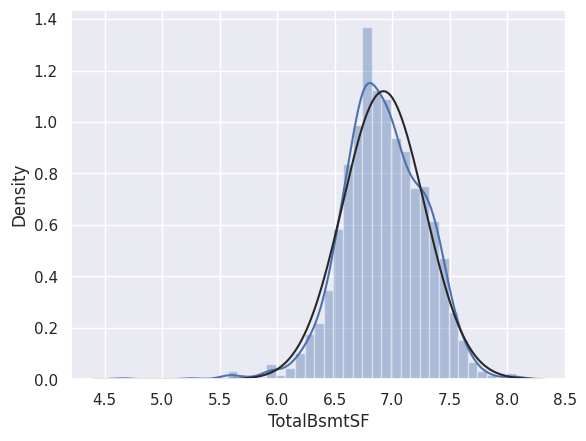

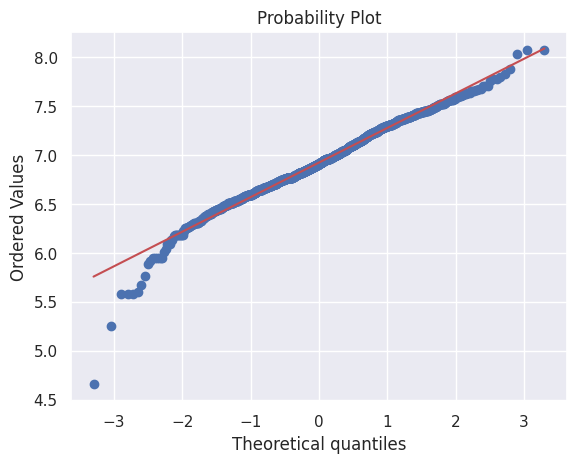

In [293]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

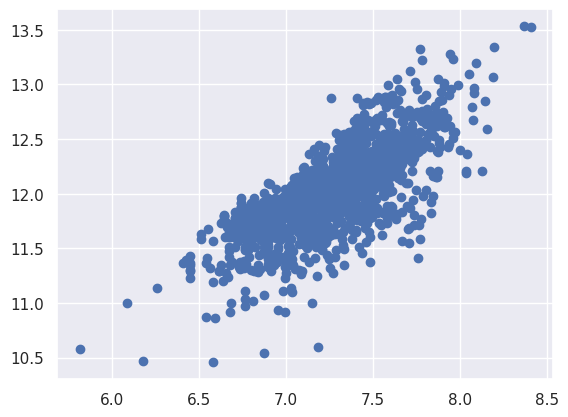

In [294]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

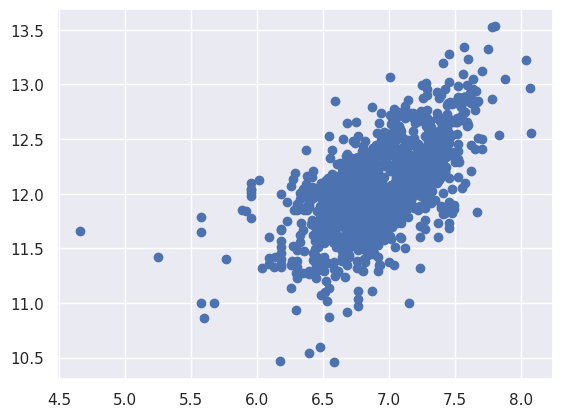

In [295]:
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

In [296]:
# df_train = pd.get_dummies(df_train)

In [297]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

regressor=xgb.XGBRegressor(eval_metric='rmsle')

# try out every combination of the above values
y_train = df_train['SalePrice']
X_train = df_train.drop('SalePrice', axis=1)

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

ValueError: 
All the 90 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 1588, in _init
    it.reraise()
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 624, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/opt/conda/lib/python3.10/site-packages/xgboost/data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
  File "/opt/conda/lib/python3.10/site-packages/xgboost/data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:MSZoning: object, Street: object, LotShape: object, LandContour: object, Utilities: object, LotConfig: object, LandSlope: object, Neighborhood: object, Condition1: object, Condition2: object, BldgType: object, HouseStyle: object, RoofStyle: object, RoofMatl: object, Exterior1st: object, Exterior2nd: object, ExterQual: object, ExterCond: object, Foundation: object, Heating: object, HeatingQC: object, CentralAir: object, Electrical: object, KitchenQual: object, Functional: object, PavedDrive: object, SaleType: object, SaleCondition: object


In [ ]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')
# df_test = pd.get_dummies(df_test)

regressor.fit(X_train, y_train)

predictions = regressor.predict(df_test)